# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values.

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [3]:
%%sh

pip install kagglehub

In [4]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.**

For a detailed description of the dataset features, please refer to  **Appendix 1** below.

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split.

In [5]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data;
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:**

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

<span style="color:lightblue"> The objective of this project is to develop a machine learning model that can accurately predict property tax valuations. In business terms, we will create a tool that supports better decision-making for various stakeholders in the real estate market.


**1.2:**  How will your solution be used?

<span style="color:lightblue">The value in being able to predict house tax value can support a mix of stakeholders in the real estate world. First, accurate tax predictions are useful for real estate investors, enabling them to see over- or under- valued properties. As tax evaluations are used in loan risk, accurately predicting them can help banks manage that risk more effectively. Also, having a tool that predicts tax valuations can help homeowners determine if they are being overcharged in terms of taxation from their local municipality. And real estate platforms like Zillow can help by estimating tax valuations when they do not have access to actual, confirmed validations.

**1.3:**  How should success (or failure) be measured?

<span style="color:lightblue">First and foremost, our model will be judged by its prediction accuracy. We will use various metrics to confirm this. We will also continually test the model’s generalizability by testing it in various real estate markets. We will also track adoption and usage to see if our customers find this tool useful and, once deemed successfully, we will track the overall trust our customers have in the tool as we go forward.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process.
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

parcelid  airconditioningtypeid  architecturalstyletypeid  basementsqft  \
0  14297519                    NaN                       NaN           NaN   
1  17052889                    NaN                       NaN           NaN   
2  14186244                    NaN                       NaN           NaN   
3  12177905                    NaN                       NaN           NaN   
4  10887214                    1.0                       NaN           NaN   

   bathroomcnt  bedroomcnt  buildingclasstypeid  buildingqualitytypeid  \
0          3.5         4.0                  NaN                    NaN   
1          1.0         2.0                  NaN                    NaN   
2          2.0         3.0                  NaN                    NaN   
3          3.0         4.0                  NaN                    8.0   
4          3.0         3.0                  NaN                    8.0   

   calculatedbathnbr  decktypeid  finishedfloor1squarefeet  \
0                3.5         NaN                       NaN   
1                1.0         NaN                    1465.0   
2                2.0         NaN                       NaN   
3                3.0         NaN                       NaN   
4                3.0         NaN                       NaN   

   calculatedfinishedsquarefeet  finishedsquarefeet12  finishedsquarefeet13  \
0                        3100.0                3100.0                   NaN   
1                        1465.0                1465.0                   NaN   
2                        1243.0                1243.0                   NaN   
3                        2376.0                2376.0                   NaN   
4                        1312.0                1312.0                   NaN   

   finishedsquarefeet15  finishedsquarefeet50  finishedsquarefeet6    fips  \
0                   NaN                   NaN                  NaN  6059.0   
1                   NaN                1465.0                  NaN  6111.0   
2                   NaN                   NaN                  NaN  6059.0   
3                   NaN                   NaN                  NaN  6037.0   
4                   NaN                   NaN                  NaN  6037.0   

   fireplacecnt  fullbathcnt  garagecarcnt  garagetotalsqft hashottuborspa  \
0           NaN          3.0           2.0            633.0            NaN   
1           1.0          1.0           1.0              0.0            NaN   
2           NaN          2.0           2.0            440.0            NaN   
3           NaN          3.0           NaN              NaN            NaN   
4           NaN          3.0           NaN              NaN            NaN   

   heatingorsystemtypeid    latitude    longitude  lotsizesquarefeet  poolcnt  \
0                    NaN  33634931.0 -117869207.0             4506.0      NaN   
1                    NaN  34449266.0 -119281531.0            12647.0      NaN   
2                    NaN  33886168.0 -117823170.0             8432.0      1.0   
3                    2.0  34245180.0 -118240722.0            13038.0      1.0   
4                    2.0  34185120.0 -118414640.0           278581.0      1.0   

   poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
0          NaN           NaN          NaN          NaN   
1          NaN           NaN          NaN          NaN   
2          NaN           NaN          NaN          1.0   
3          NaN           NaN          NaN          1.0   
4          NaN           NaN          NaN          1.0   

  propertycountylandusecode  propertylandusetypeid propertyzoningdesc  \
0                       122                  261.0                NaN   
1                      1110                  261.0                NaN   
2                       122                  261.0                NaN   
3                      0101                  261.0         LCR110000*   
4                      010C                  266.0               LAR3   

   rawcensustractandblock  r

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [ ]:
# Finding which features have null values for more than 50% of the examples

null_percentage = df.isnull().mean() * 100

df_filtered = df.loc[:, null_percentage >= 50]

In [ ]:
df_filtered.isnull().mean()

airconditioningtypeid       0.677799
architecturalstyletypeid    0.997333
basementsqft                0.999356
buildingclasstypeid         0.999807
decktypeid                  0.992089
finishedfloor1squarefeet    0.922217
finishedsquarefeet13        0.999459
finishedsquarefeet15        0.960999
finishedsquarefeet50        0.922217
finishedsquarefeet6         0.995027
fireplacecnt                0.893201
garagecarcnt                0.671189
garagetotalsqft             0.671189
hashottuborspa              0.980171
poolcnt                     0.791607
poolsizesum                 0.988803
pooltypeid10                0.994009
pooltypeid2                 0.986162
pooltypeid7                 0.805716
regionidneighborhood        0.600917
storytypeid                 0.999356
threequarterbathnbr         0.869790
typeconstructiontypeid      0.997127
yardbuildingsqft17          0.969168
yardbuildingsqft26          0.999098
numberofstories             0.773247
fireplaceflag               0.997784
t

In [ ]:
df_filtered.describe()

airconditioningtypeid  architecturalstyletypeid  basementsqft  \
count           25007.000000                207.000000     50.000000   
mean                1.812013                  7.386473    679.720000   
std                 2.965768                  2.728030    689.703546   
min                 1.000000                  2.000000     38.000000   
25%                 1.000000                  7.000000    273.000000   
50%                 1.000000                  7.000000    515.000000   
75%                 1.000000                  7.000000    796.500000   
max                13.000000                 21.000000   3560.000000   

       buildingclasstypeid  decktypeid  finishedfloor1squarefeet  \
count            15.000000       614.0               6037.000000   
mean              3.933333        66.0               1366.165314   
std               0.258199         0.0                670.701336   
min               3.000000        66.0                 44.000000   
25%               4.000000        66.0                955.000000   
50%               4.000000        66.0               1257.000000   
75%               4.000000        66.0               1615.000000   
max               4.000000        66.0               6912.000000   

       finishedsquarefeet13  finishedsquarefeet15  finishedsquarefeet50  \
count             42.000000           3027.000000           6037.000000   
mean            1388.761905           2354.491245           1381.388935   
std              122.220874           1186.985442            725.792665   
min             1056.000000            598.000000             44.000000   
25%             1344.000000           1624.000000            956.000000   
50%             1440.000000           2088.000000           1259.000000   
75%             1440.000000           2831.000000           1621.000000   
max             1560.000000          35640.000000          12467.000000   

       finishedsquarefeet6  fireplacecnt  garagecarcnt  garagetotalsqft  \
count           386.000000   8289.000000  25520.000000     25520.000000   
mean           2082.500000      1.191217      1.815282       350.047061   
std            1240.382784      0.490980      0.588340       261.646070   
min             380.000000      1.000000      0.000000         0.000000   
25%             993.750000      1.000000      2.000000         0.000000   
50%            1812.500000      1.000000      2.000000       436.000000   
75%            3053.500000      1.000000      2.000000       492.000000   
max            5598.000000      5.000000     14.000000      4251.000000   

       poolcnt  poolsizesum  pooltypeid10  pooltypeid2  pooltypeid7  \
count  16174.0   869.000000         465.0       1074.0      15079.0   
mean       1.0   517.930955           1.0          1.0          1.0   
std        0.0   156.569664           0.0          0.0          0.0   
min        1.0    24.000000           1.0          1.0          1.0   
25%        1.0   424.000000           1.0          1.0          1.0   
50%        1.0   500.000000           1.0          1.0          1.0   
75%        1.0   600.000000           1.0          1.0          1.0   
max        1.0  1500.000000           1.0          1.0          1.0   

       regionidneighborhood  storytypeid  threequarterbathnbr  \
count          30974.000000         50.0         10106.000000   
mean          187725.110544          7.0             1.009598   
std           165045.086058          0.0             0.118572   
min             6952.000000          7.0             1.000000   
25%            46736.000000          7.0             1.000000   
50%           118849.000000          7.0             1.000000   
75%           274765.000000          7.0             1.000000   
max           764167.000000          7.0             7.000000   

       typeconstructiontypeid  yardbuildingsqft17  yardbuildingsqft26  \
count              223.000000         2393.000000           70.000000   
mean                 

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

The following features are categorical
- parcelid
- airconditioningtypeid
- architecturalstyletypeid
- buildingclasstypeid
- buildingqualitytypeid
- decktypeid
- heatingorsystemtypeid
- hashottuborspa
- pooltypeid10
- pooltypeid2,
- pooltypeid7
- propertycountylandusecode
- propertylandusetypeid
- propertyzoningdesc
- regionidcity
- regionidcounty
- regionidneighborhood
- regionidzip
- storytypeid
- typeconstructiontypeid
- fireplaceflag
- taxdelinquencyflag

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly.


parcelid:


rawcensustractandblock: This is an unprocessed identifier for census tract and block, which doesn't provide direct value-related informatio

threequarterbathnbr: Not a very common or informative feature.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example.

The following values have null percentages above 50% which would be a good indicator that they appear to be useless.

 airconditioningtypeid,
 architecturalstyletypeid,
 basementsqft,
 buildingclasstypeid,
 decktypeid,
 finishedfloor1squarefeet,
 finishedsquarefeet13,
 finishedsquarefeet15,
 finishedsquarefeet50,
 finishedsquarefeet6,
 fireplacecnt,
 garagecarcnt,
 garagetotalsqft,
 hashottuborspa,
 poolcnt,
 poolsizesum,
 pooltypeid10,
 pooltypeid2,
 pooltypeid7,
 regionidneighborhood,
 storytypeid,
 threequarterbathnbr,
 typeconstructiontypeid,
 yardbuildingsqft17,
 yardbuildingsqft26,
 numberofstories,
 fireplaceflag,
 taxdelinquencyflag,
 taxdelinquencyyear

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example.

The regionidcounty and regionidcity features both have a large amount of unique values that they would not add any value to predictions. In a dataset with 77,613 there are around 77,000 values for both features effectively making them useless.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

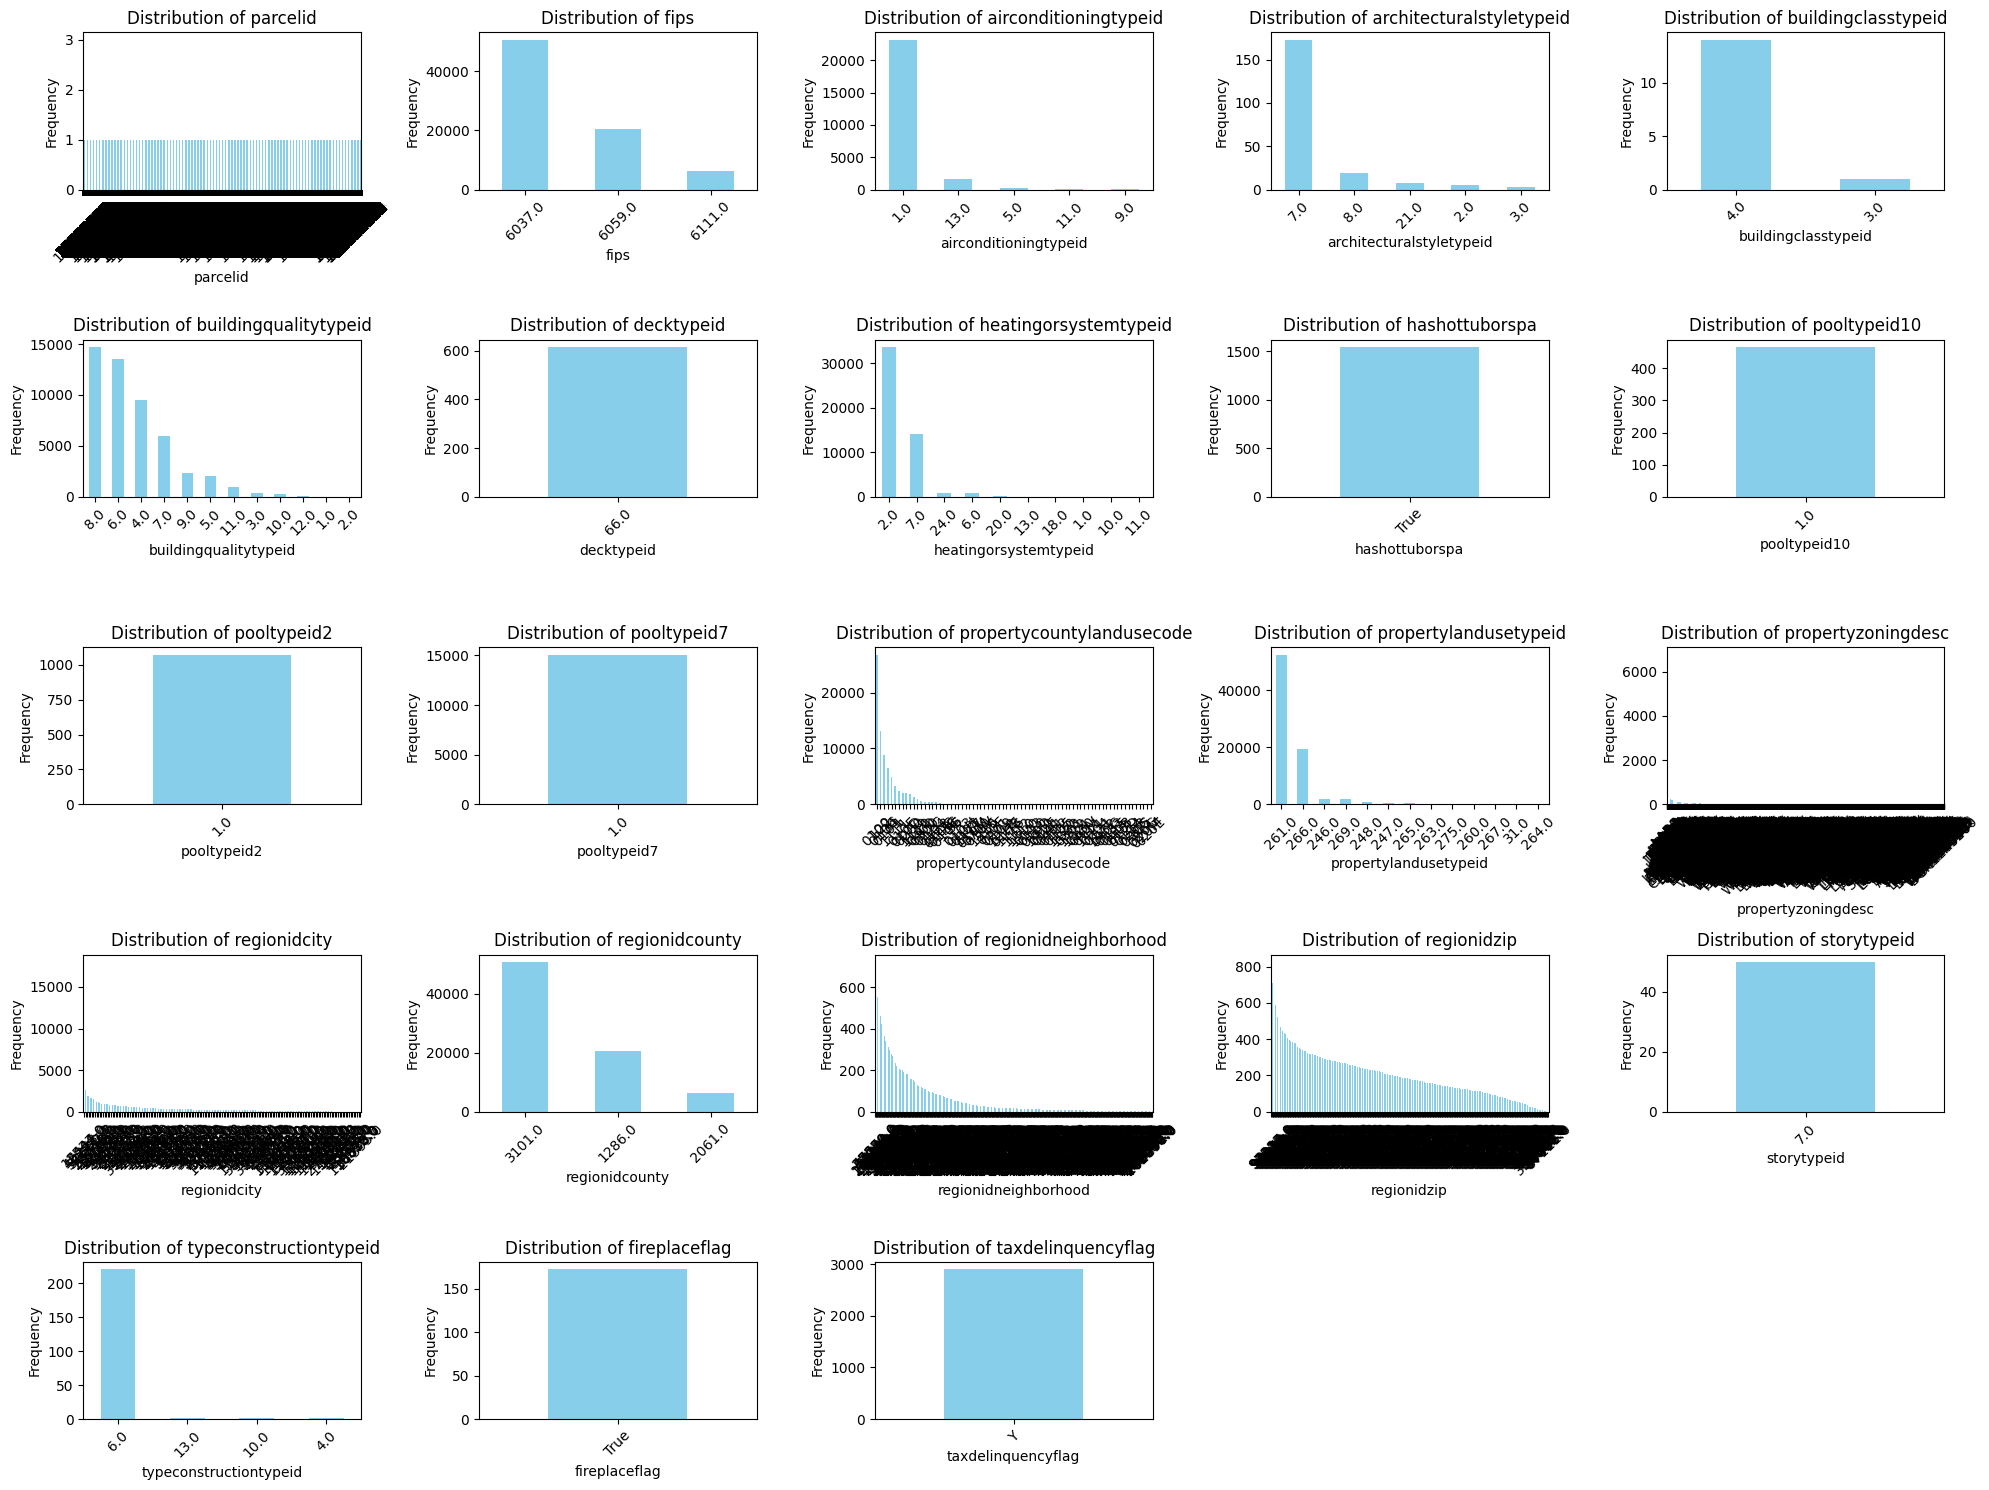

In [ ]:
# Provides bar chart for categorical data
df_non_numeric = [
                    "parcelid",
                    "fips",
                    "airconditioningtypeid",
                    "architecturalstyletypeid",
                    "buildingclasstypeid",
                    "buildingqualitytypeid",
                    "decktypeid",
                    "heatingorsystemtypeid",
                    "hashottuborspa",
                    "pooltypeid10",
                    "pooltypeid2",
                    "pooltypeid7",
                    "propertycountylandusecode",
                    "propertylandusetypeid",
                    "propertyzoningdesc",
                    "regionidcity",
                    "regionidcounty",
                    "regionidneighborhood",
                    "regionidzip",
                    "storytypeid",
                    "typeconstructiontypeid",
                    "fireplaceflag",
                    "taxdelinquencyflag",
                ]






df_non_numeric = df[df_non_numeric]

plt.figure(figsize=(20, 15))

for i, column in enumerate(df_non_numeric.columns, 1):
    plt.subplot(5, 5, i)
    df_non_numeric[column].value_counts().plot(kind='bar', color='skyblue')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
df_numeric = df.drop(df_non_numeric, axis=1)

<Figure size 2000x1500 with 0 Axes>

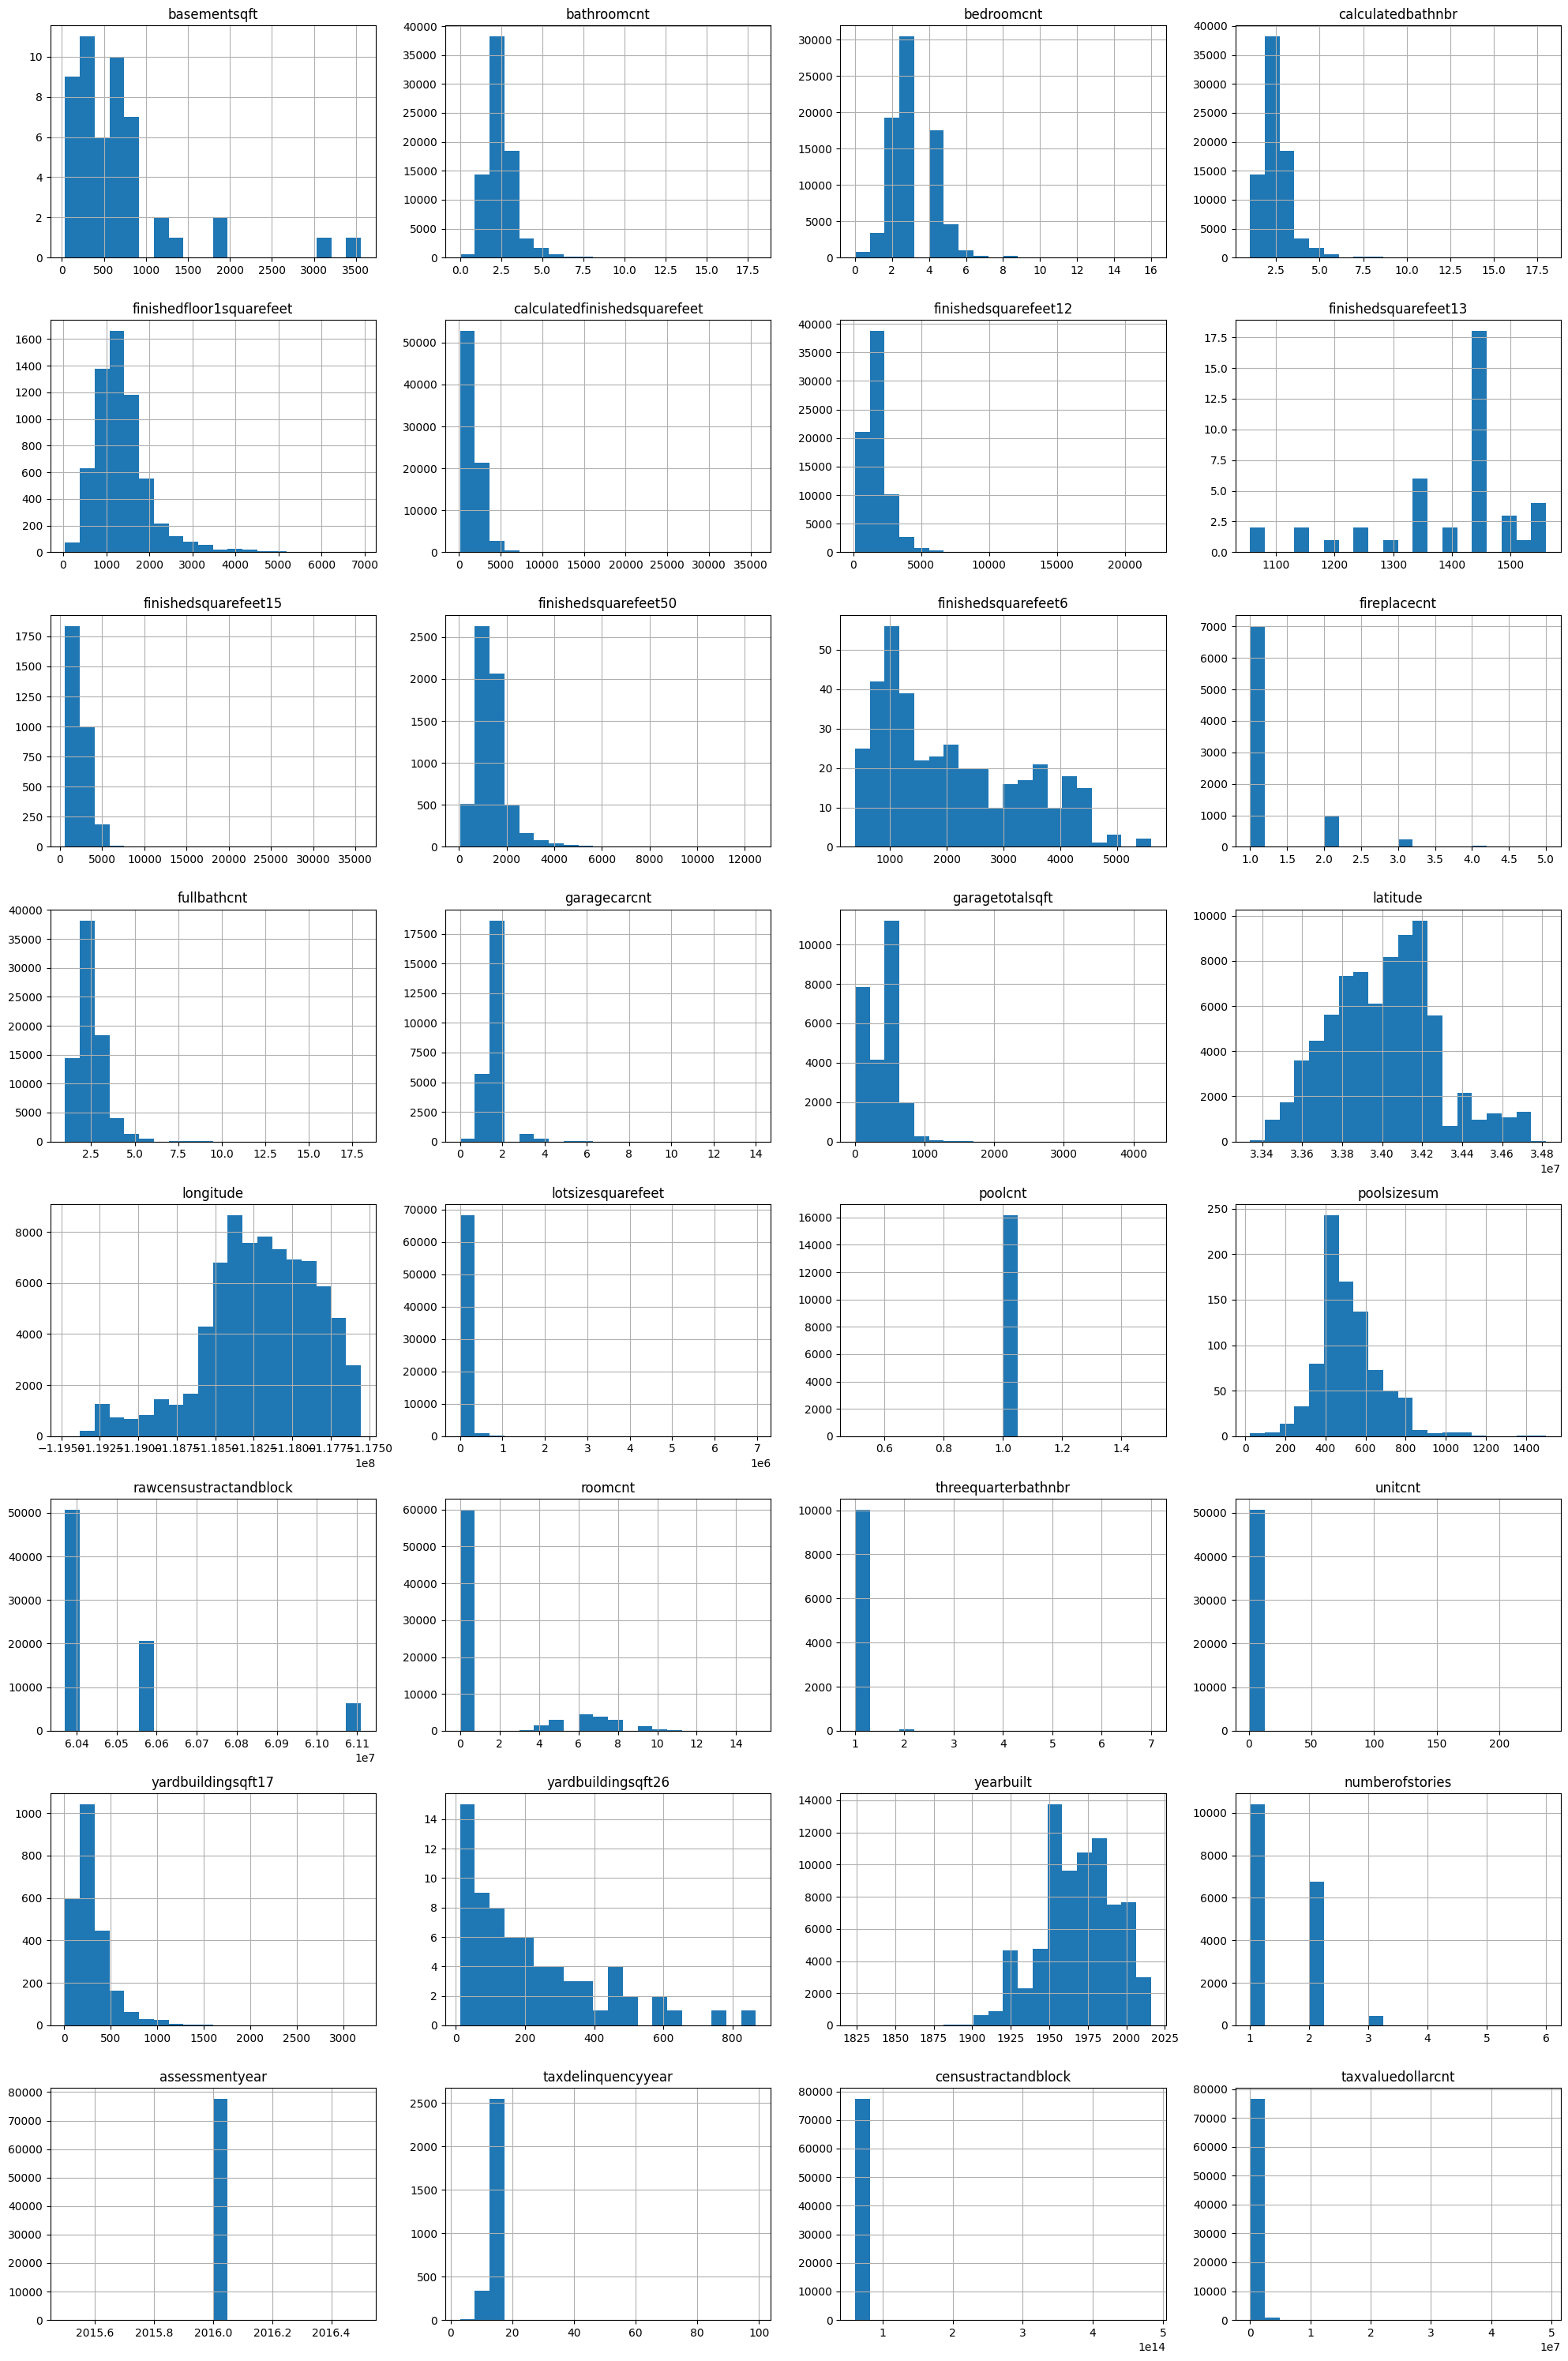

In [ ]:
# Provides histograms for numerical data
plt.figure(figsize=(20, 15))
df_numeric.hist(bins=20, figsize=(20, 30), layout=(-1, 4))

plt.tight_layout()
plt.show()


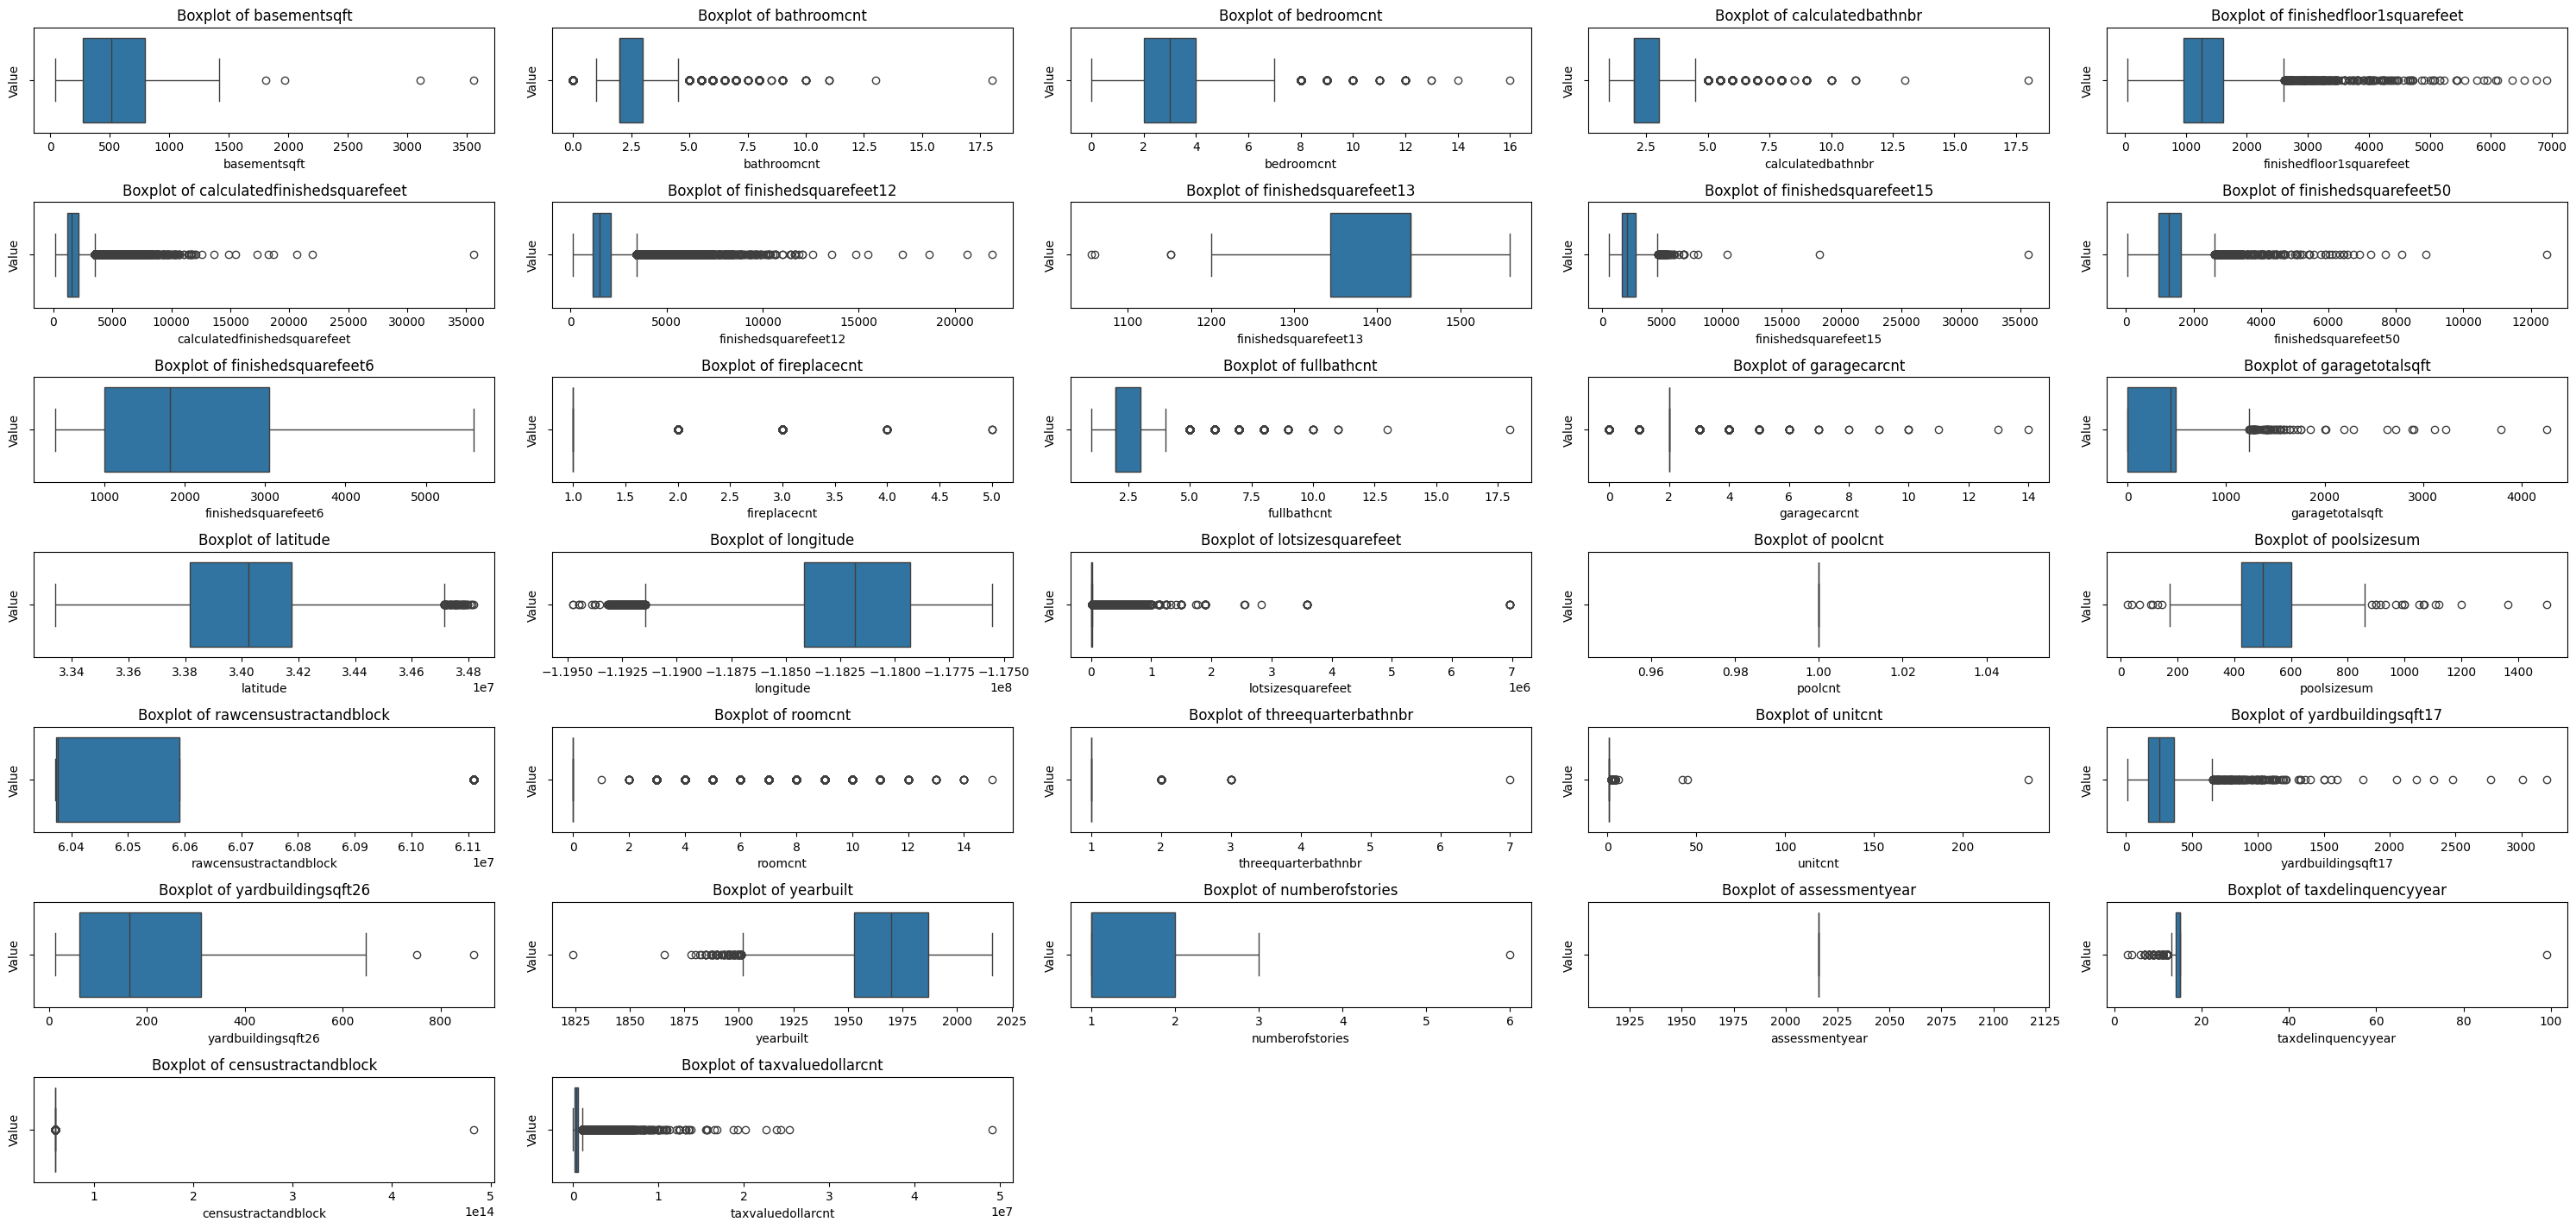

In [ ]:
import seaborn as sns

plt.figure(figsize=(30, 20))

for i, column in enumerate(df_numeric.columns, 1):
    plt.subplot(10, 5, i)
    sns.boxplot(x=df_numeric[column])
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

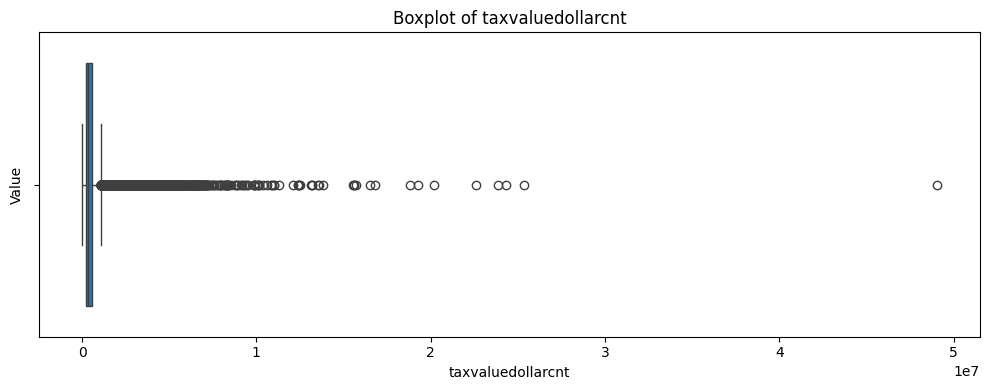

In [ ]:
# Looking more in depth at the target variable

target = "taxvaluedollarcnt"

plt.figure(figsize=(10, 4))
sns.boxplot(x=df_numeric[target])
plt.xlabel(target)
plt.ylabel('Value')
plt.title(f'Boxplot of {target}')

plt.tight_layout()
plt.show()

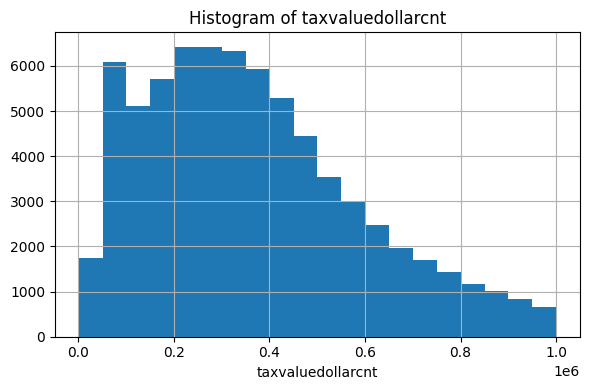

In [ ]:
# Removing outliers based on arbitrary threshold

df_taxval = pd.DataFrame(df_numeric[df_numeric['taxvaluedollarcnt'] < 1000000][target])
df_taxval.hist(bins=20, figsize=(6, 4))
plt.xlabel(target)
plt.title(f'Histogram of {target}')

plt.tight_layout()
plt.show()

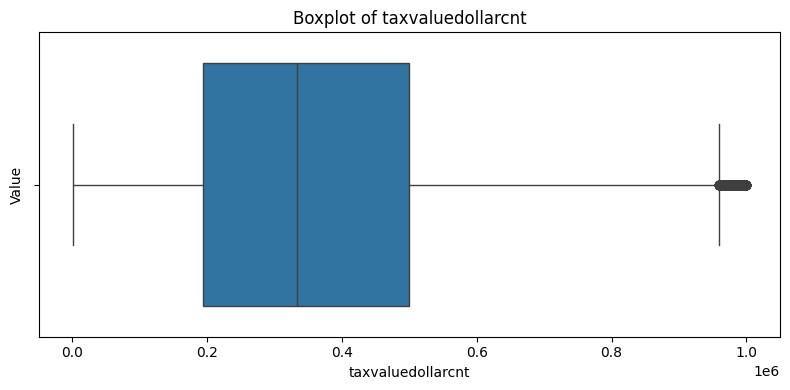

In [ ]:
# Removing outliers based on arbitrary threshold

plt.figure(figsize=(8, 4))
sns.boxplot(x=df_taxval[target])
plt.xlabel(target)
plt.ylabel('Value')
plt.title(f'Boxplot of {target}')

plt.tight_layout()
plt.show()

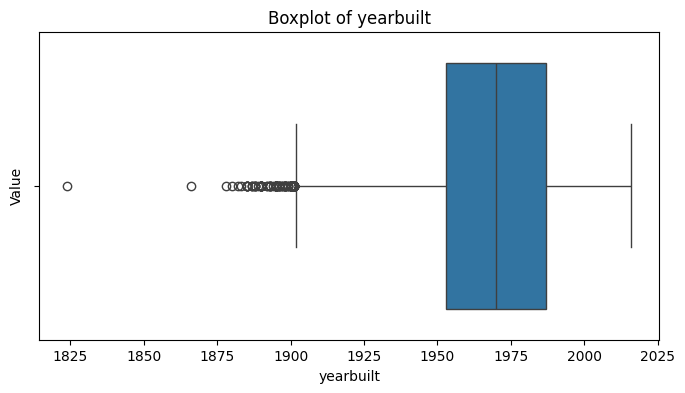

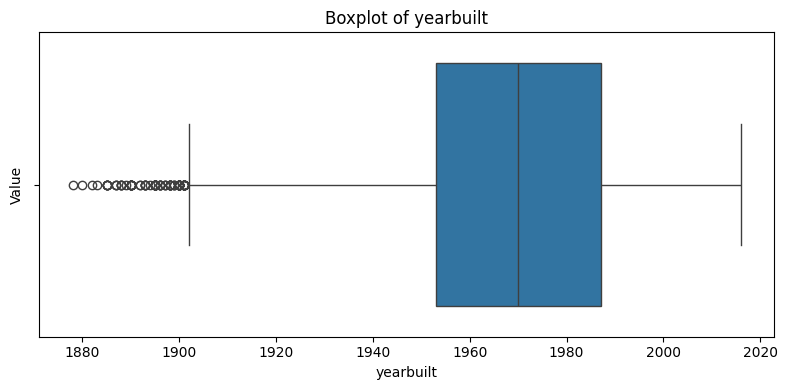

In [ ]:
# Looking more closely at boxplot
feature1 = "yearbuilt"
df_f1 = pd.DataFrame(df_numeric[feature1])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_f1[feature1])
plt.xlabel(feature1)
plt.ylabel('Value')
plt.title(f'Boxplot of {feature1}')

df_f1 = pd.DataFrame(df_numeric[df_numeric[feature1] > 1877][feature1])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_f1[feature1])
plt.xlabel(feature1)
plt.ylabel('Value')
plt.title(f'Boxplot of {feature1}')

plt.tight_layout()
plt.show()

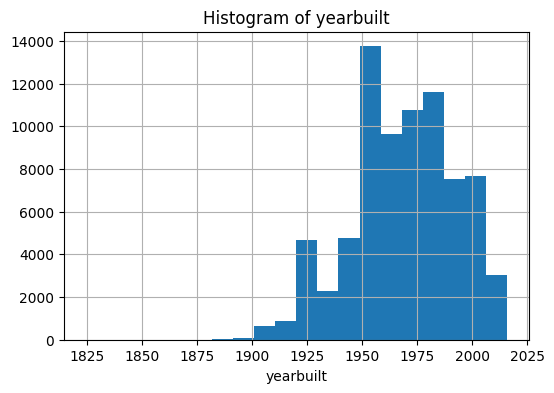

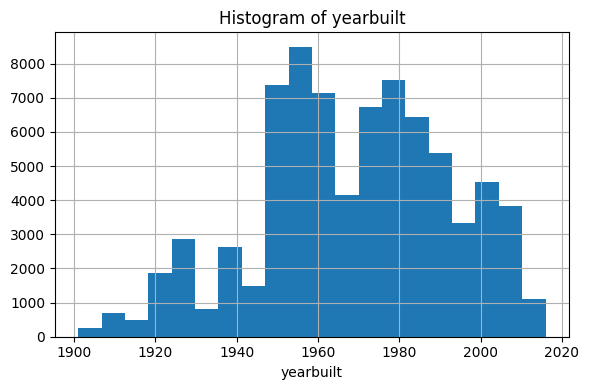

In [ ]:
# Removing outliers based on arbitrary threshold
df_f1 = pd.DataFrame(df_numeric[feature1])
df_f1.hist(bins=20, figsize=(6, 4))
plt.xlabel(feature1)
plt.title(f'Histogram of {feature1}')

df_f1 = pd.DataFrame(df_numeric[df_numeric[feature1] > 1900][feature1])
df_f1.hist(bins=20, figsize=(6, 4))
plt.xlabel(feature1)
plt.title(f'Histogram of {feature1}')

plt.tight_layout()
plt.show()

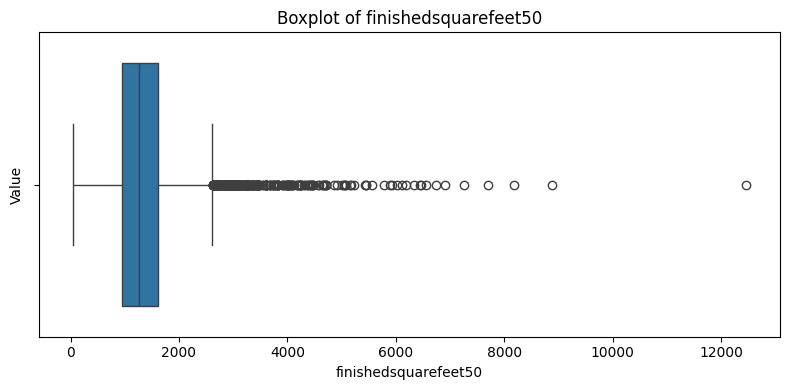

In [ ]:
# Removing outliers based on arbitrary threshold
feature2 = "finishedsquarefeet50"

df_f2 = pd.DataFrame(df_numeric[feature2])
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_f2[feature2])
plt.xlabel(feature2)
plt.ylabel('Value')
plt.title(f'Boxplot of {feature2}')

plt.tight_layout()
plt.show()

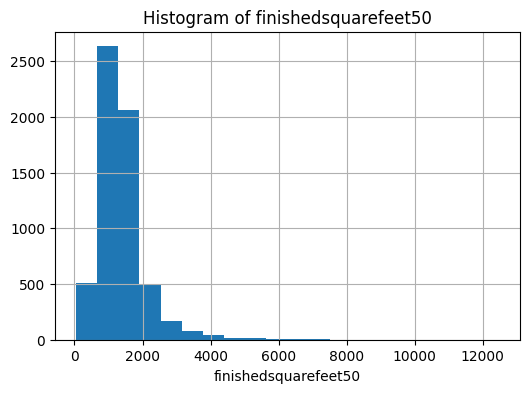

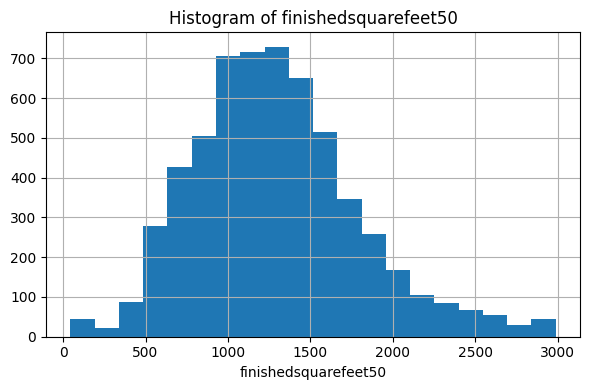

In [ ]:
# Histogram with outliers removed

df_f2 = pd.DataFrame(df_numeric[feature2])
df_f2.hist(bins=20, figsize=(6, 4))
plt.xlabel(feature2)
plt.title(f'Histogram of {feature2}')


df_f2 = pd.DataFrame(df_numeric[df_numeric[feature2] < 3000][feature2])
df_f2.hist(bins=20, figsize=(6, 4))
plt.xlabel(feature2)
plt.title(f'Histogram of {feature2}')

plt.tight_layout()
plt.show()

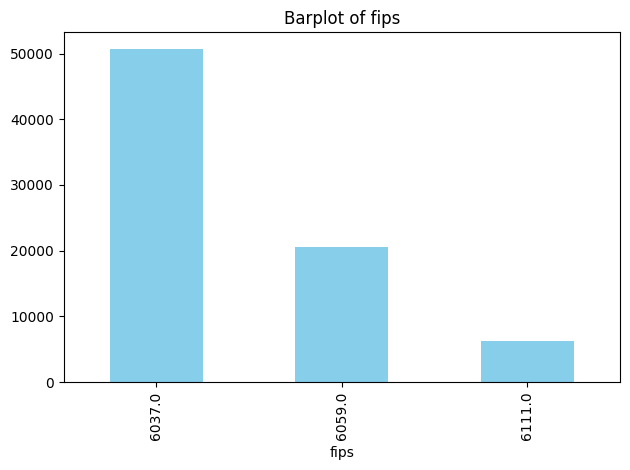

In [ ]:
feature3 = "fips"

df_f3 = pd.DataFrame(df_non_numeric[feature3])
df_f3[feature3].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel(feature3)
plt.title(f'Barplot of {feature3}')

plt.tight_layout()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Some features with approximately normal distributions include finishedfloor1squarefeet, finishedsquarefeet50, calculatedbathnbr, and poolsizenum

Looks like a lot of the binary variables have null values instead of saying false

In the target feature taxvaluecnt, there are a significant amount of outliers that limits visibility into the histogram. Once these outliers are removed, the distribution becomes more normal, still being skewed right. The distribution of the feature originally was skewed left, but once outliers are removed it approaches a more normal distribution. This yearbuilt feature was chosen because age of the property should have major impacts to the value and understanding the distribution of this feature can provide insight into our target. The distribution of the feature originally was skewed right, but once outliers are removed it approaches a more normal distribution. The finishedsquarefeet50 feature was chosen because at first glance it had a more normal distribution when compared to other features. Furthermore, this feature deals with the area of the homes which can offer information too the pricing/value of the property. The fips feature seems to be imbalanced with more than half of the examples belonging to one category. However, geological information can provide insight into the value of a property. This imbalance might signify that a different geological feature should be used over this one.







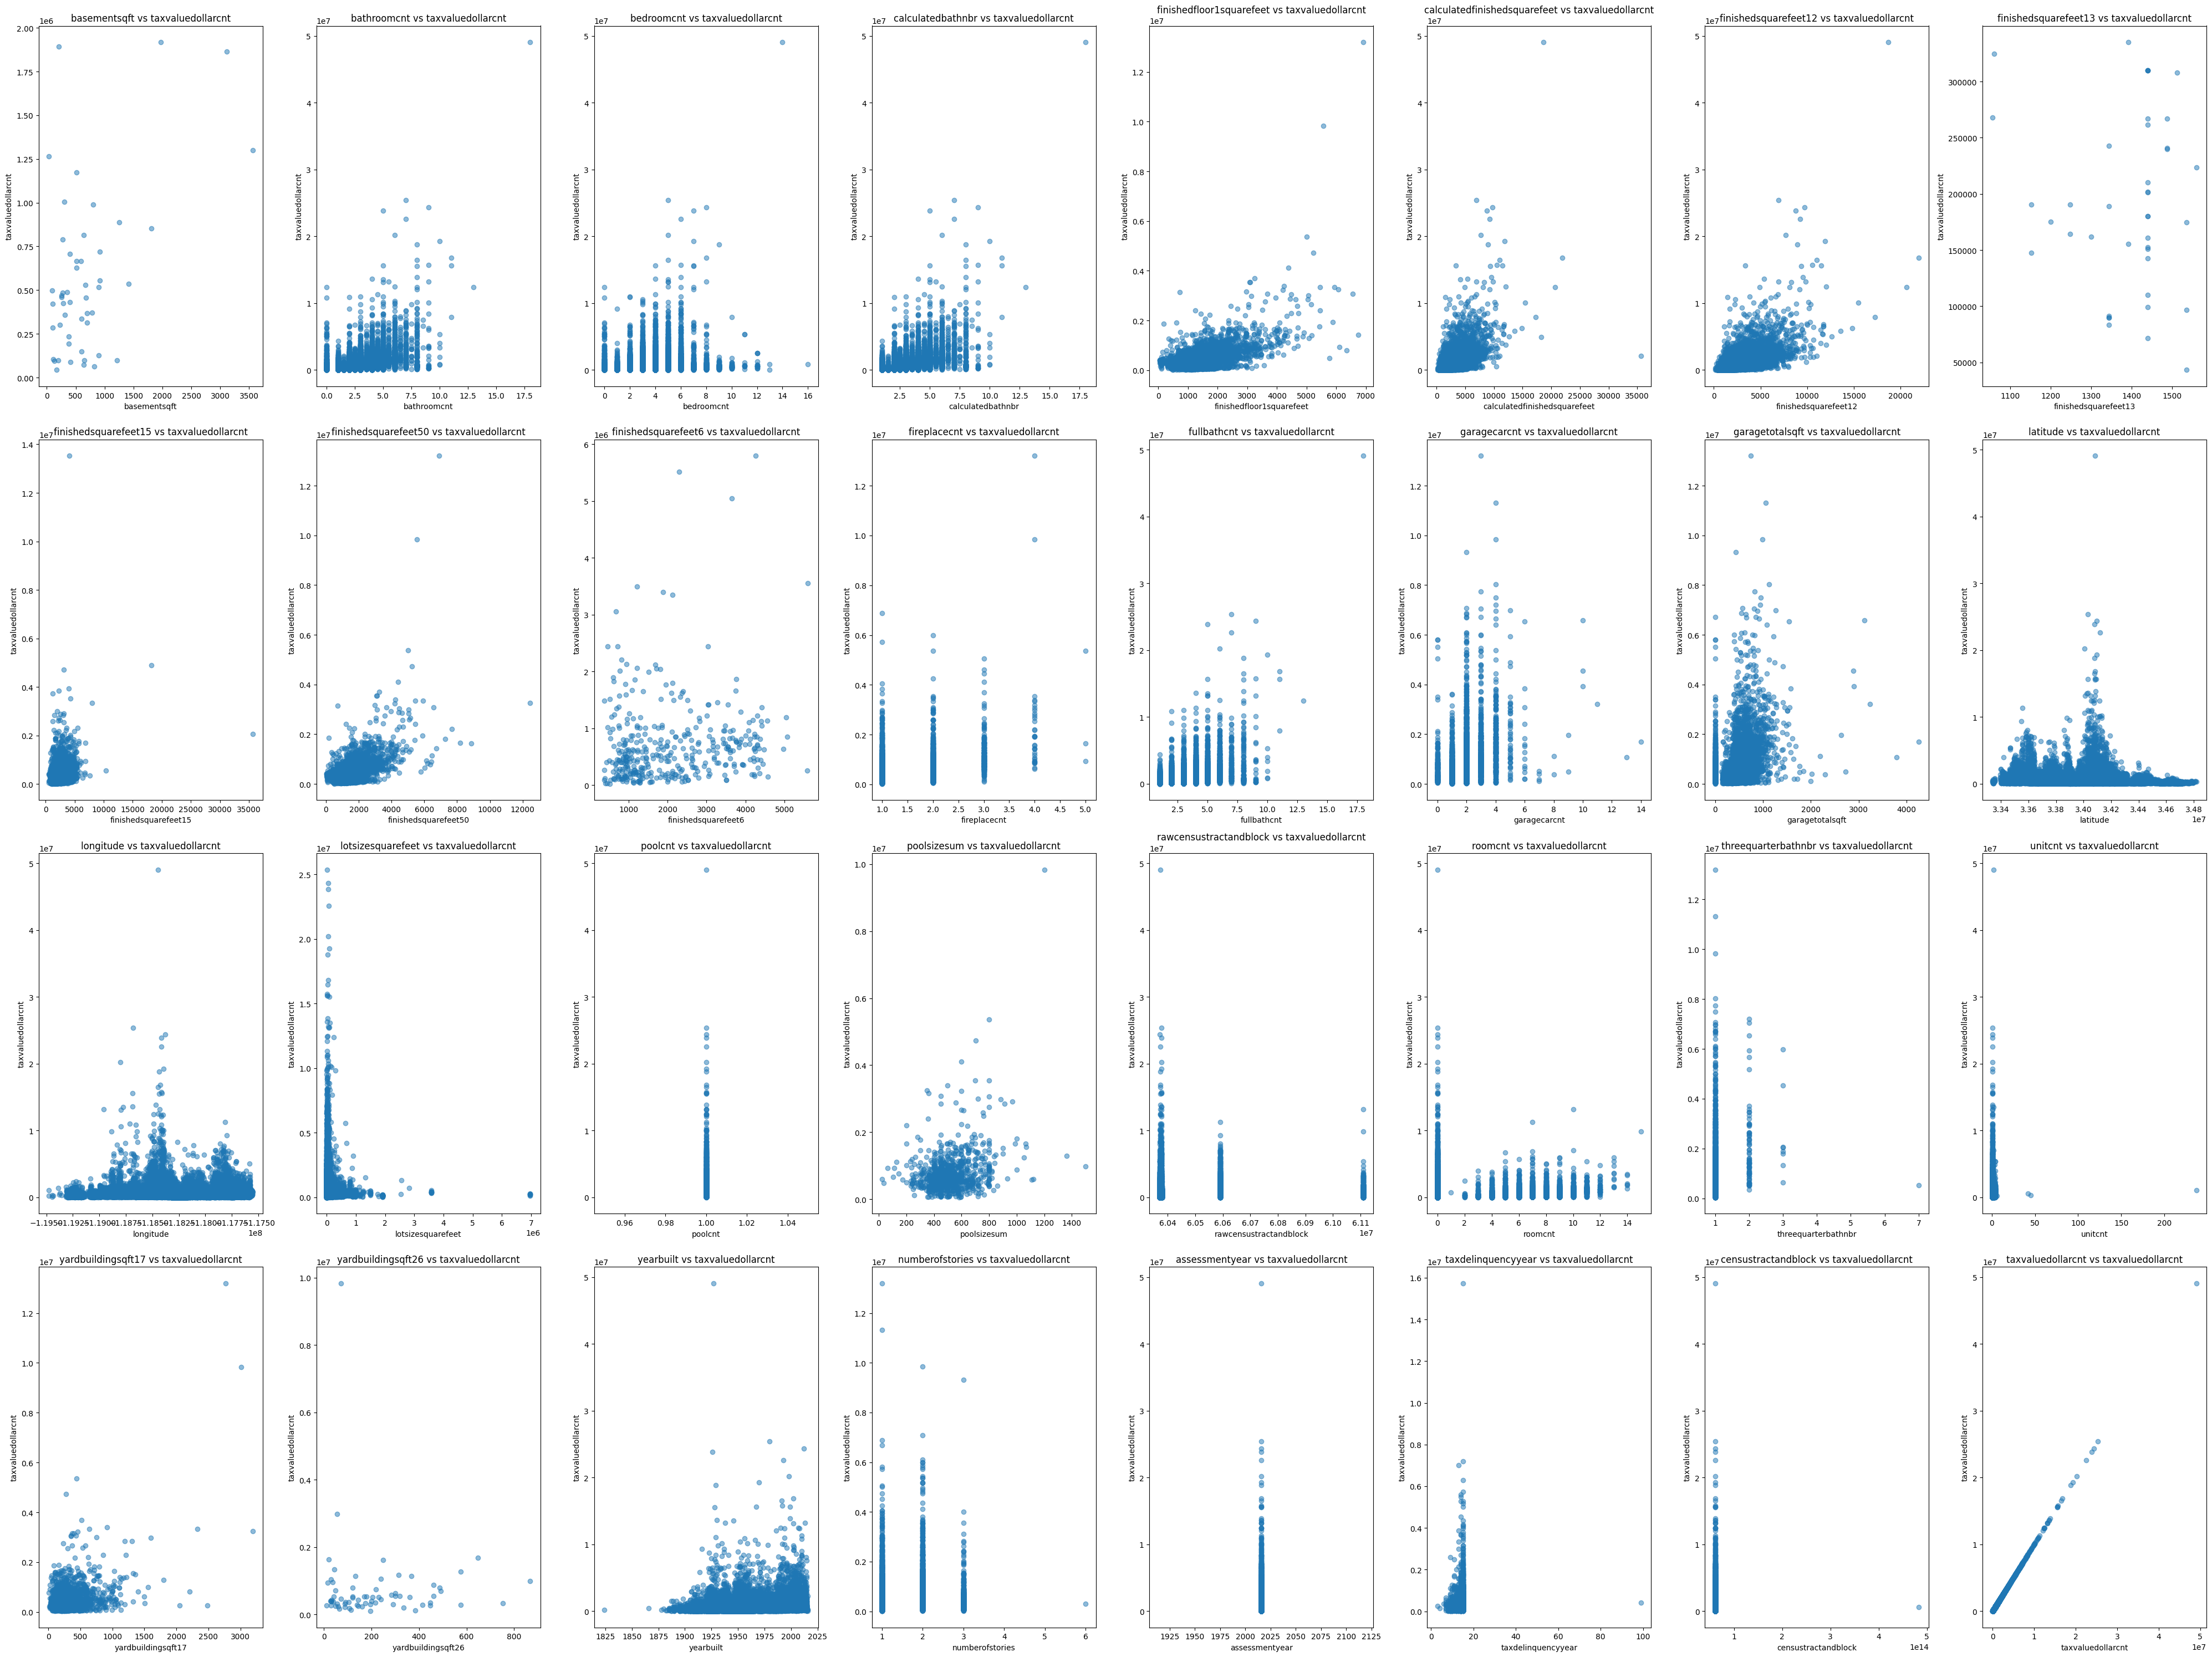

In [ ]:
features = df_numeric = df.drop(df_non_numeric, axis=1).columns.tolist()

fig, axes = plt.subplots(nrows=4, ncols=len(features)//4, figsize=(40, 30))

axes = axes.flatten()

target = 'taxvaluedollarcnt'

for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(df[feature], df[target], alpha=0.5)
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel(feature)
    ax.set_ylabel(target)

# Adjust layout
plt.tight_layout()

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task!

In [19]:
df_cleaned = df.drop(columns=['fips', 'regionidneighborhood', 'hashottuborspa', 'threequarterbathnbr',
                              'fireplaceflag', 'pooltypeid10', 'censustractandblock', 'assessmentyear'])
len(df_cleaned.columns)

47

#### **3.A Discussion:**

A total of 8 columns were dropped due to a lack of contribution to the data. Multiple features were observed to offer redundant information within the dataset, as is the case with "fireplaceflag", "regionidneighborhood", or "fips". Other variables were dropped at this stage since they are believed to have a low significance to the target variable. For example, "pooltype10" represents properties that have hot tubs or spas, but not pools, which is unlikely to contribute to the tax value of the property. Finally, "assessmentyear" was removed due to all the values being the same.


### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully.

In [20]:
high_null_columns = [
    'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid',
    'decktypeid', 'finishedsquarefeet13', 'finishedsquarefeet15',
    'finishedsquarefeet6', 'poolsizesum', 'storytypeid',
    'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26',
    'finishedfloor1squarefeet', 'finishedsquarefeet50',
    'airconditioningtypeid', 'numberofstories'
]

df_cleaned = df_cleaned.drop(columns=high_null_columns)

### taxdelinquencyflag - Could fill w/ 0
### taxdelinquencyyear - Could fill w/ 0
### fireplacecnt - Could fill w/ 0
### garagecarcnt - Could fill w/ 0
### garagetotalsqft - Could fill w/ 0
### poolcnt	- Could fill w/ 0

len(df_cleaned.columns)



31

In [21]:
# Pool Type Columns
pooltype_columns = ['pooltypeid2', 'pooltypeid7']

df_cleaned['pooltypeid_merged'] = df_cleaned[pooltype_columns].max(axis=1)
df_cleaned = df_cleaned.drop(columns=['pooltypeid2', 'pooltypeid7'])

len(df_cleaned.columns)

30

#### **3.B Discussion:**

Generally, we would want to remove any columns that have a percentage of null values higher than 50%, however in this datset, doing so would eliminate more than half of our features. Therefore we determined it better to assign or impute as many of the variables as possible. This decisions comes with a risk of introducing bias into the model, and therefore was only used for variables whose null values were either known or reasonably assumed to be 0s or negatives (False). A total of 16 variables were removed due to their high percentage of null values.

Additionally, the two remaining columns for "pooltypeid" were merged into a single column to reduce the number of null values in either feature and because it is believed that the information relating to a general presence of a pool is more valuable to the model than the less complete information relating to the type of pool. Therefore the two original columns were dropped.

### Part 3.C: Drop Problematic **samples**

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [22]:
# Drop target null values
df_cleaned = df_cleaned.dropna(subset=["taxvaluedollarcnt"])


Number of outliers in log variable: 2092


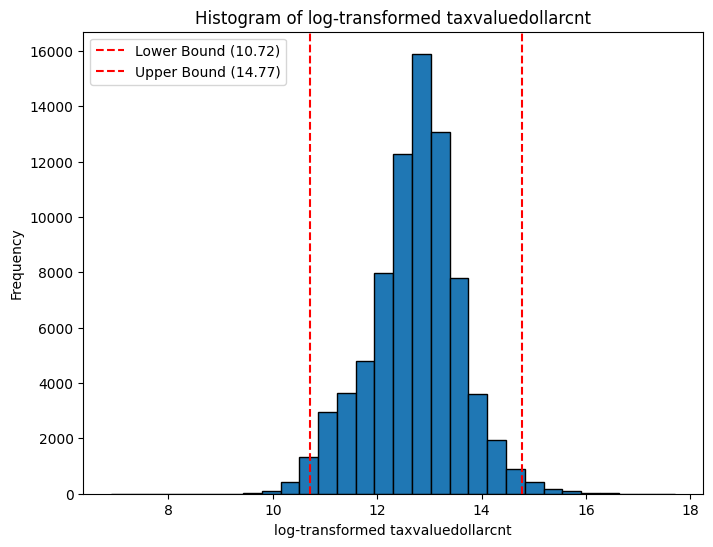

In [23]:
# Target Log Transformation
df_cleaned['log_taxvaluedollarcnt'] = np.log1p(df['taxvaluedollarcnt'])
df_cleaned = df_cleaned.drop(columns='taxvaluedollarcnt')

# Calculate IQR
Q1 = df_cleaned['log_taxvaluedollarcnt'].quantile(0.25)
Q3 = df_cleaned['log_taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_cleaned[(df_cleaned['log_taxvaluedollarcnt'] < lower_bound) | (df_cleaned['log_taxvaluedollarcnt'] > upper_bound)]
num_outliers = outliers.shape[0]
print(f'Number of outliers in log variable: {num_outliers}')

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(df_cleaned['log_taxvaluedollarcnt'], bins=30, edgecolor='black')
plt.axvline(lower_bound, color='red', linestyle='dashed', label=f'Lower Bound ({lower_bound:.2f})')
plt.axvline(upper_bound, color='red', linestyle='dashed', label=f'Upper Bound ({upper_bound:.2f})')
plt.xlabel('log-transformed taxvaluedollarcnt')
plt.ylabel('Frequency')
plt.title('Histogram of log-transformed taxvaluedollarcnt')
plt.legend()
plt.show()

#### **3.C Discussion:**

All of the missing or null values within the target column (taxvaluedollarcnt) were dropped. This only affected about 35 rows, which is a very small percentage of the data.

In order to reduce the skewness and number of outliers within the data, we transformed the target variable with a log function. This greatly decreased the number of outliers within the target and made the variable distribution much more normal, and thus the outliers that did remain were not removed.

Additionally, rows with too many null values (more than half of the features) were dropped. However, this number was determined and removal was performed after imputation in the next part.


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [24]:
# Common Value (0)

impute_columns = ['taxdelinquencyflag', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'poolcnt', 'pooltypeid_merged']
df_cleaned[impute_columns] = df_cleaned[impute_columns].fillna(0)
df_cleaned['taxdelinquencyyear'] = df_cleaned['taxdelinquencyyear'].fillna("None")

### taxdelinquencyflag - Could fill w/ 0
### taxdelinquencyyear - Could fill w/ None
### fireplacecnt - Could fill w/ 0
### garagecarcnt - Could fill w/ 0
### garagetotalsqft - Could fill w/ 0
### poolcnt	- Could fill w/ 0

In [25]:
# Drop rows with 5 or more null values

null_count = df_cleaned.isnull().sum(axis=1)
df_cleaned = df_cleaned[null_count < 5]

#### **3.D Discussion:**  

Six columns, all of which were determined to have nulls that represented 0 or "None", were filled in to eliminate the presence of any null values. As mentioned previously, this likely will introduce bias into the future model, as it is impossible to know how many of the assigned values for each feature are incorrect.

Additionally, rows that contained 5 or more null values were removed. About half of the observations within the data contain at least 1 null value, which means a high percentage of the data would be removed if all null values were erased. A large majority (about 90%) of those rows were determine to have less than 5; therefore a threshold of 5 was selected in order to elimate rows with a relatively high number of null values without removing too much of the data.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary.

In [26]:
categorical_columns = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid',
                    'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip']
unique_counts = df[categorical_columns].nunique()
print(unique_counts)

buildingqualitytypeid           12
heatingorsystemtypeid           10
propertycountylandusecode       75
propertylandusetypeid           13
rawcensustractandblock       39188
regionidcity                   175
regionidcounty                   3
regionidzip                    389
dtype: int64


In [27]:
# One-Hot Encoding (<20)

one_hot = ['buildingqualitytypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'regionidcounty']

df_cleaned = pd.get_dummies(df_cleaned, columns=one_hot, drop_first=True)

In [28]:
# Frequency Encoding (>20)

freq_encode = ['propertycountylandusecode', 'regionidcity', 'regionidzip']

for col in freq_encode:
    df_cleaned[col] = df_cleaned[col].map(df_cleaned[col].value_counts() / len(df_cleaned))


In [29]:
# Final Dataset

df_cleaned

parcelid  bathroomcnt  bedroomcnt  calculatedbathnbr  \
0      14297519          3.5         4.0                3.5   
1      17052889          1.0         2.0                1.0   
2      14186244          2.0         3.0                2.0   
3      12177905          3.0         4.0                3.0   
4      10887214          3.0         3.0                3.0   
...         ...          ...         ...                ...   
77608  10833991          3.0         3.0                3.0   
77609  11000655          2.0         2.0                2.0   
77610  17239384          2.0         4.0                2.0   
77611  12773139          1.0         3.0                1.0   
77612  12826780          2.0         3.0                2.0   

       calculatedfinishedsquarefeet  finishedsquarefeet12  fireplacecnt  \
0                            3100.0                3100.0           0.0   
1                            1465.0                1465.0           1.0   
2                            1243.0                1243.0           0.0   
3                            2376.0                2376.0           0.0   
4                            1312.0                1312.0           0.0   
...                             ...                   ...           ...   
77608                        1741.0                1741.0           0.0   
77609                        1286.0                1286.0           0.0   
77610                        1612.0                1612.0           1.0   
77611                        1032.0                1032.0           0.0   
77612                        1762.0                1762.0           0.0   

       fullbathcnt  garagecarcnt  garagetotalsqft  ...  \
0              3.0           2.0            633.0  ...   
1              1.0           1.0              0.0  ...   
2              2.0           2.0            440.0  ...   
3              3.0           0.0              0.0  ...   
4              3.0           0.0              0.0  ...   
...            ...           ...              ...  ...   
77608          3.0           0.0              0.0  ...   
77609          2.0           0.0              0.0  ...   
77610          2.0           2.0            560.0  ...   
77611          1.0           0.0              0.0  ...   
77612          2.0           0.0              0.0  ...   

       propertylandusetypeid_261.0  propertylandusetypeid_263.0  \
0                             True                        False   
1                             True                        False   
2                             True                        False   
3                             True                        False   
4                            False                        False   
...                            ...                          ...   
77608                        False                        False   
77609                         True                        False   
77610                         True                        False   
77611                         True                        False   
77612                         True                        False   

       propertylandusetypeid_264.0  propertylandusetypeid_265.0  \
0                            False                        False   
1                            False                        False   
2                            False                        False   
3                            False                        False   
4                            False                        False   
...                            ...                          ...   
77608                        False                        False   
77609                        False                        False   
77610                        False                        False   
77611                        False                        False   
77612                        False                        False   

       propertylandusetypeid_266.0 propert

In [30]:
df_cleaned.to_csv("zillow_dataset_cleaned.csv", index=False)

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project.

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well).
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments.

In [ ]:
# Let's do pairwise correlation analysis to find out which features are correlated with each other.

#make a copy of the cleaned dataframe
df_cleaned_4a = df_cleaned.copy()

#choose non-nonumeric columns and replace true/false with 1/0
non_numeric_cols = df_cleaned_4a.select_dtypes(exclude=['number']).columns
df_cleaned_4a_bool = df_cleaned.map(lambda x: 1 if x is True else (0 if x is False else x))

#drop Non-numeric columns:'propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear',
df_cleaned_4a_corr = df_cleaned_4a_bool.drop(columns=['propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear'])

#do the correlation analysis
correlation_matrix = df_cleaned_4a_corr.corr(method='pearson')

#get upper triangle of the correlation matrix
matrix_upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

#find pairs with strong correlation
strong_corrs = matrix_upper[(matrix_upper > 0.7) | (matrix_upper < -0.7)].stack().reset_index()
strong_corrs.columns = ['Variable 1', 'Variable 2', 'Correlation']

#find pairs with moderate correlation
moderate_corrs = matrix_upper[(matrix_upper > 0.3) & (matrix_upper <= 0.7) |
                               (matrix_upper < -0.3) & (matrix_upper >= -0.7)].stack().reset_index()
moderate_corrs.columns = ['Variable 1', 'Variable 2', 'Correlation']

#find pairs with weak/no correlation
weak_corrs = matrix_upper[(matrix_upper <= 0.3) & (matrix_upper >= -0.3)].stack().reset_index()
weak_corrs.columns = ['Variable 1', 'Variable 2', 'Correlation']


# NOTE: I decided to only keep the strong correlations for now.
top_strong_corrs = strong_corrs.sort_values(by='Correlation', ascending=False)
# top10_moderate_corrs = moderate_corrs.sort_values(by='Correlation', ascending=False).head(10)
# top10_weak_corrs = weak_corrs.sort_values(by='Correlation', ascending=False).head(10)

top_strong_corrs

Variable 1                    Variable 2  Correlation
0                    bathroomcnt             calculatedbathnbr     1.000000
7   calculatedfinishedsquarefeet          finishedsquarefeet12     1.000000
16                       poolcnt             pooltypeid_merged     0.999154
6              calculatedbathnbr                   fullbathcnt     0.987761
3                    bathroomcnt                   fullbathcnt     0.987761
10                  garagecarcnt               garagetotalsqft     0.942699
18        rawcensustractandblock         regionidcounty_2061.0     0.896464
5              calculatedbathnbr          finishedsquarefeet12     0.812963
2                    bathroomcnt          finishedsquarefeet12     0.811449
4              calculatedbathnbr  calculatedfinishedsquarefeet     0.809231
1                    bathroomcnt  calculatedfinishedsquarefeet     0.797281
9           finishedsquarefeet12                   fullbathcnt     0.788399
8   calculatedfinishedsquarefeet                   fullbathcnt     0.786074
12                  garagecarcnt                       roomcnt     0.780250
17        rawcensustractandblock                       roomcnt     0.752376
11                  garagecarcnt        rawcensustractandblock     0.741484
14               garagetotalsqft                       roomcnt     0.733769
21                       unitcnt   propertylandusetypeid_248.0     0.702826
19        rawcensustractandblock         regionidcounty_3101.0    -0.792729
22   propertylandusetypeid_261.0   propertylandusetypeid_266.0    -0.805880
20                       roomcnt         regionidcounty_3101.0    -0.831622
15               garagetotalsqft         regionidcounty_3101.0    -0.856523
13                  garagecarcnt         regionidcounty_3101.0    -0.924941

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

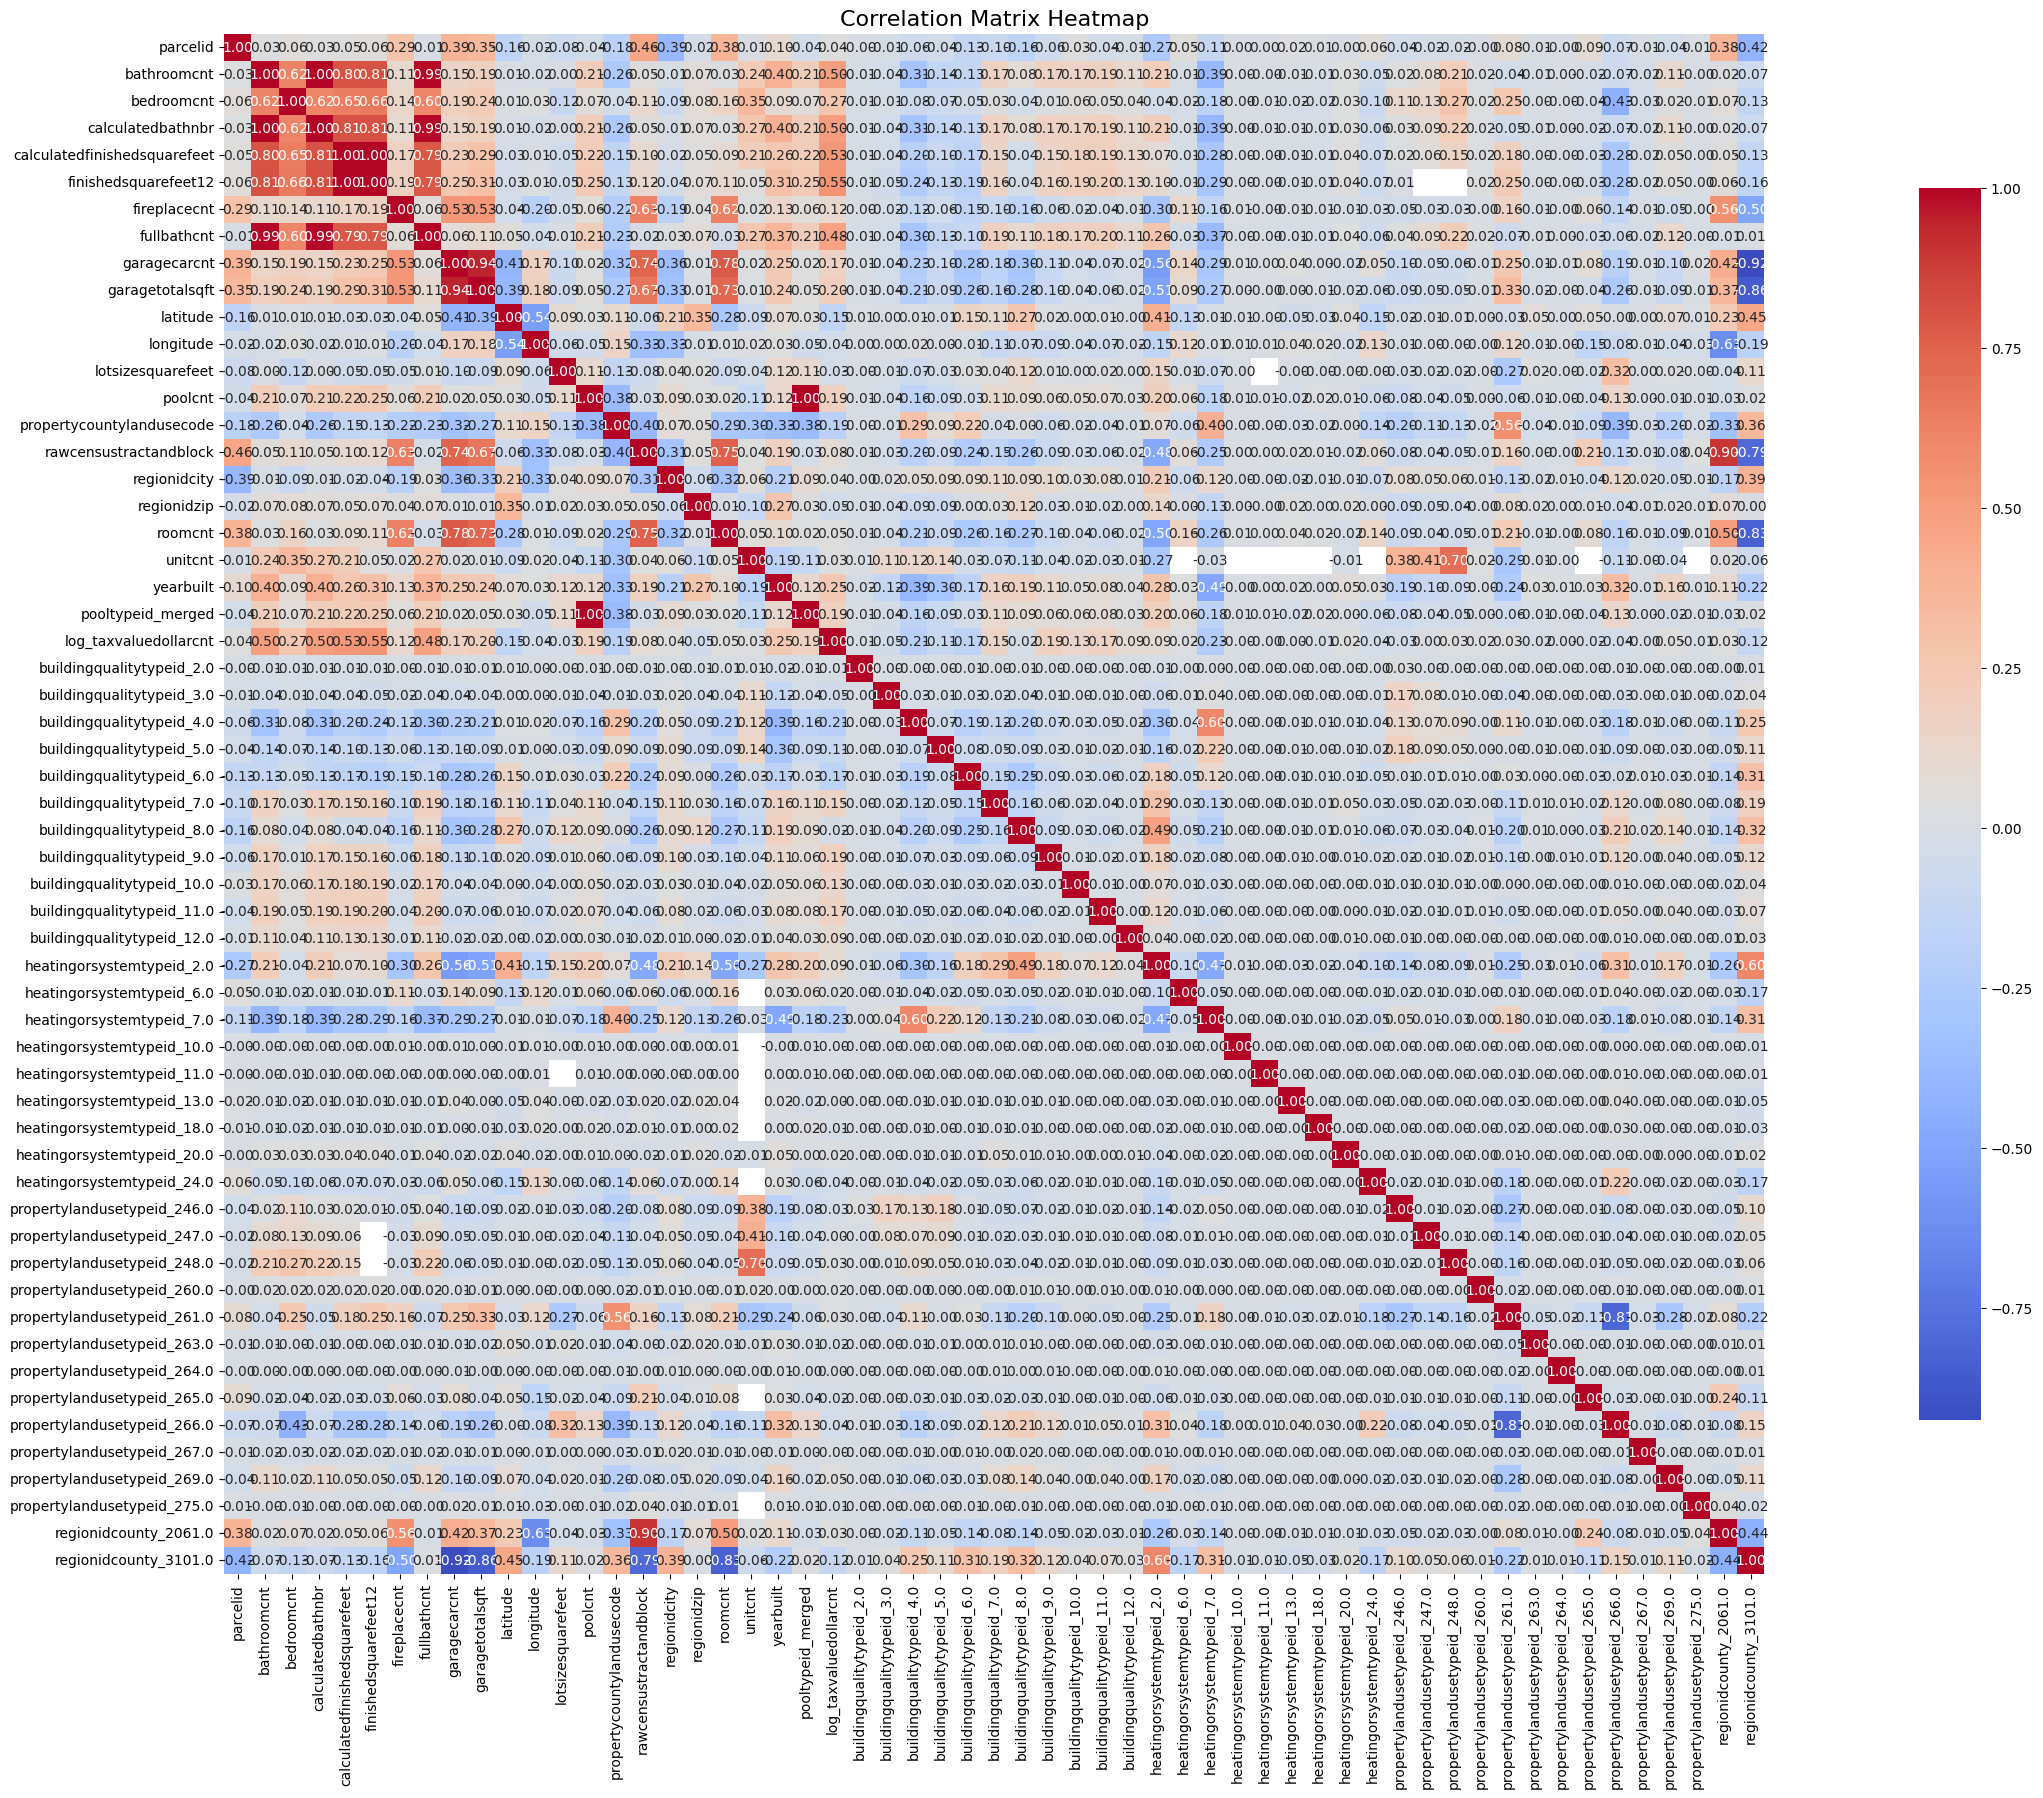

In [ ]:
#4a - Heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

#set figure size for better readability
plt.figure(figsize=(40, 20))

#create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': 0.8})

#add a title
plt.title("Correlation Matrix Heatmap", fontsize=16)

In [ ]:
#before we can do the f-statistic test, we need to handle the NaN values in the dataset.
#let's select the columsn with NaN values and see what they look like

nan_summary = df_cleaned_4a_corr.isnull().sum()
nan_summary[nan_summary > 0]

#count NaN values for each column
nan_columns = nan_summary[nan_summary > 0].index

#create a new DataFrame with NaN columns and show 5 values of each
nan_df = df_cleaned_4a_corr[nan_columns].head()

nan_df


calculatedbathnbr  calculatedfinishedsquarefeet  finishedsquarefeet12  \
0                3.5                        3100.0                3100.0   
1                1.0                        1465.0                1465.0   
2                2.0                        1243.0                1243.0   
3                3.0                        2376.0                2376.0   
4                3.0                        1312.0                1312.0   

   fullbathcnt  lotsizesquarefeet  regionidcity  regionidzip  unitcnt  \
0          3.0             4506.0      0.008955     0.004195      NaN   
1          1.0            12647.0      0.002528     0.002500      NaN   
2          2.0             8432.0      0.008051     0.005876      NaN   
3          3.0            13038.0      0.001921     0.003630      1.0   
4          3.0           278581.0      0.253743     0.002020      1.0   

   yearbuilt  
0     1998.0  
1     1967.0  
2     1962.0  
3     1970.0  
4     1964.0

In [ ]:
#So, now let's impute the NaN's with suggested replacements and the check that all Nan's are gone. So output should be 0.

df_cleaned_4a_f = df_cleaned_4a_corr.copy()

#Impute numeric columns with mean
numeric_cols = ['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
                'lotsizesquarefeet', 'regionidcity', 'regionidzip']
df_cleaned_4a_f[numeric_cols] = df_cleaned_4a_f[numeric_cols].fillna(df_cleaned_4a_f[numeric_cols].mean())

#Impute specific columns with median
median_cols = ['fullbathcnt', 'yearbuilt']
df_cleaned_4a_f[median_cols] = df_cleaned_4a_f[median_cols].fillna(df_cleaned_4a_f[median_cols].median())

#Impute unitcnt with mode
df_cleaned_4a_f['unitcnt'] = df_cleaned_4a_f['unitcnt'].fillna(df_cleaned_4a_f['unitcnt'].mode()[0])

df_cleaned_4a_f.isnull().sum().sum()



np.int64(0)

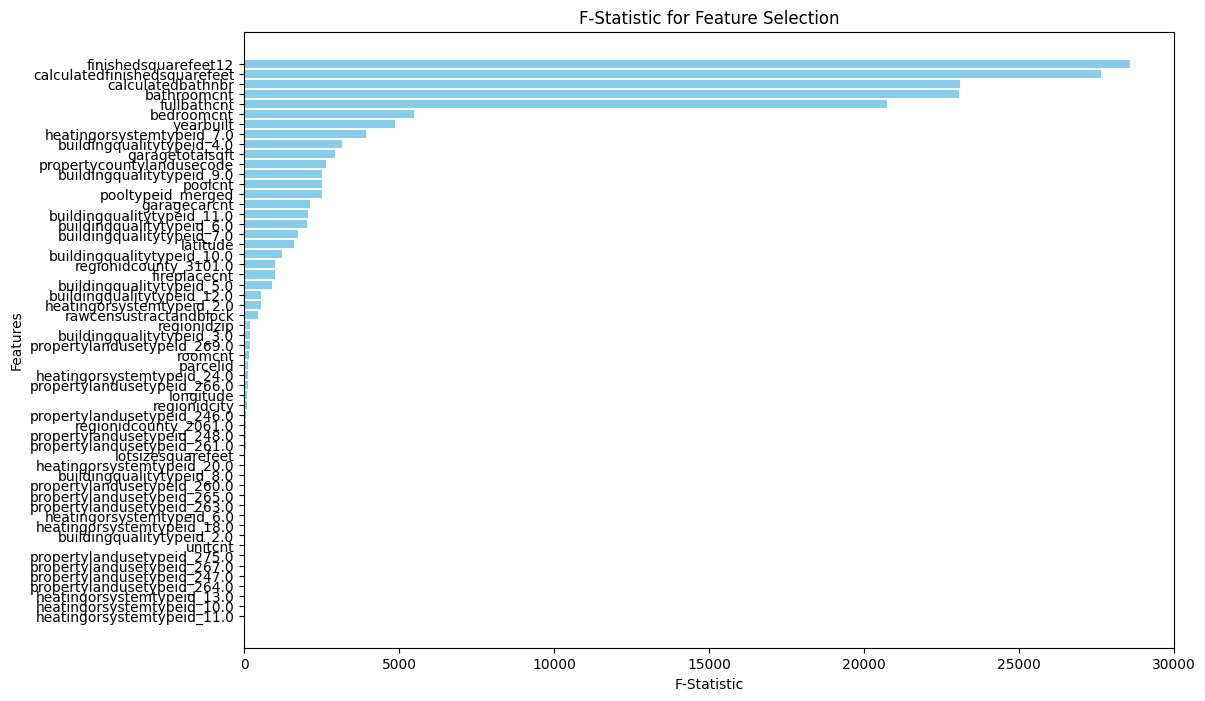

In [ ]:
from sklearn.feature_selection import f_regression
import pandas as pd
import matplotlib.pyplot as plt

# Define target variable
target = df_cleaned_4a_f['log_taxvaluedollarcnt']

# Define feature columns (excluding target column)
features = df_cleaned_4a_f.drop(columns=['log_taxvaluedollarcnt'])

# Compute F-statistic and p-values
f_stat, p_values = f_regression(features, target)

# Create a DataFrame to display results
f_stat_df = pd.DataFrame({'Feature': features.columns, 'F-Statistic': f_stat})
f_stat_df = f_stat_df.sort_values(by='F-Statistic', ascending=False)

# Plot F-statistic as a bar chart
plt.figure(figsize=(12, 8))
plt.barh(f_stat_df['Feature'], f_stat_df['F-Statistic'], color='skyblue')
plt.xlabel('F-Statistic')
plt.ylabel('Features')
plt.title('F-Statistic for Feature Selection')
plt.gca().invert_yaxis()
plt.show()


Forward Selected Features: Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt',
       'latitude', 'longitude', 'propertycountylandusecode',
       'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt',
       'yearbuilt', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0',
       'buildingqualitytypeid_5.0', 'buildingqualitytypeid_6.0',
       'buildingqualitytypeid_7.0', 'buildingqualitytypeid_8.0',
       'buildingqualitytypeid_9.0', 'buildingqualitytypeid_10.0',
       'buildingqualitytypeid_11.0', 'buildingqualitytypeid_12.0',
       'propertylandusetypeid_261.0', 'regionidcounty_2061.0',
       'regionidcounty_3101.0'],
      dtype='object')
Backward Selected Features: Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt',
       'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet',
  

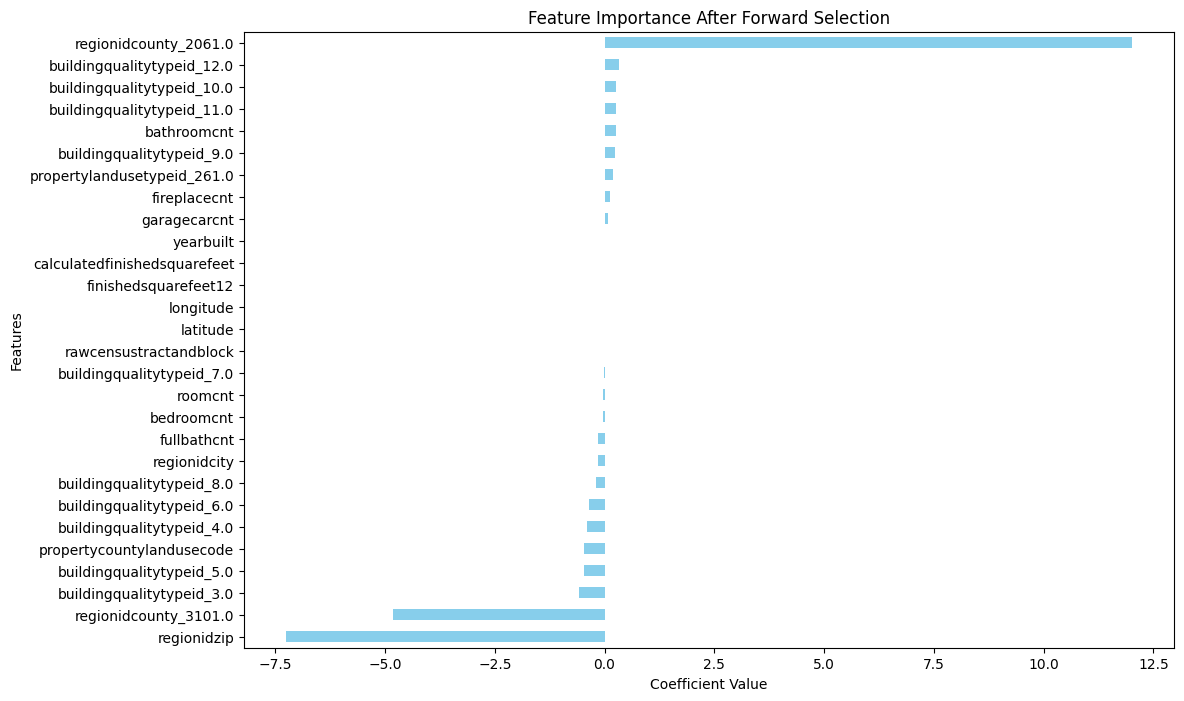

In [ ]:
#As requested, let's do forward and backward feature selection using the SequentialFeatureSelector from sklearn.

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Define target and feature variables
X = df_cleaned_4a_f.drop(columns=['log_taxvaluedollarcnt'])  # Independent variables
y = df_cleaned_4a_f['log_taxvaluedollarcnt']                # Target variable

# Create a linear regression model
model = LinearRegression()


# Forward feature selection
forward_selector = SequentialFeatureSelector(model, direction='forward', n_features_to_select='auto', cv=5)
forward_selector.fit(X, y)

# Get the selected features
forward_features = X.columns[forward_selector.get_support()]
print("Forward Selected Features:", forward_features)


# Backward feature elimination
backward_selector = SequentialFeatureSelector(model, direction='backward', n_features_to_select='auto', cv=5)
backward_selector.fit(X, y)

# Get the selected features
backward_features = X.columns[backward_selector.get_support()]
print("Backward Selected Features:", backward_features)

# Get model coefficients for forward-selected features
model.fit(X[forward_features], y)
feature_importance = pd.Series(model.coef_, index=forward_features)

# Plot feature importance
feature_importance.sort_values(ascending=True).plot(kind='barh', figsize=(12, 8), color='skyblue')
plt.title("Feature Importance After Forward Selection")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.show()

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships.
 How do the different methods for seeing relationships compare? Do they agree or disagree?

<span style="color:lightblue"> Our methods do agree on correlation. Overall, we see positive correlations for things that make structural sense from a housing perspective. For example, total garage sqft vs total garage places (counts) have a high correlation. Also, it makes sense that the number of bathrooms would correlate to overall housing squarefeet given the spacial distribution for most houses. We can disregard the almost perfect positive correlations in many cases, because we have a calculated vs actual values for things like bathroom count and total square feet.

<span style="color:lightblue"> What is very interesting is that there are location identifiers that are postively and negatively correlated to house aspects. The strongest seems to be a region id of 3101 that is negatively correlated against room and garage counts. Could this be a more economically humble area that has smaller houses? UPDATE: Upon further review, these location identifiers seem to indicate that a house is either in the location or not, so the correlation aspect isn't useful.




### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis.
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends.

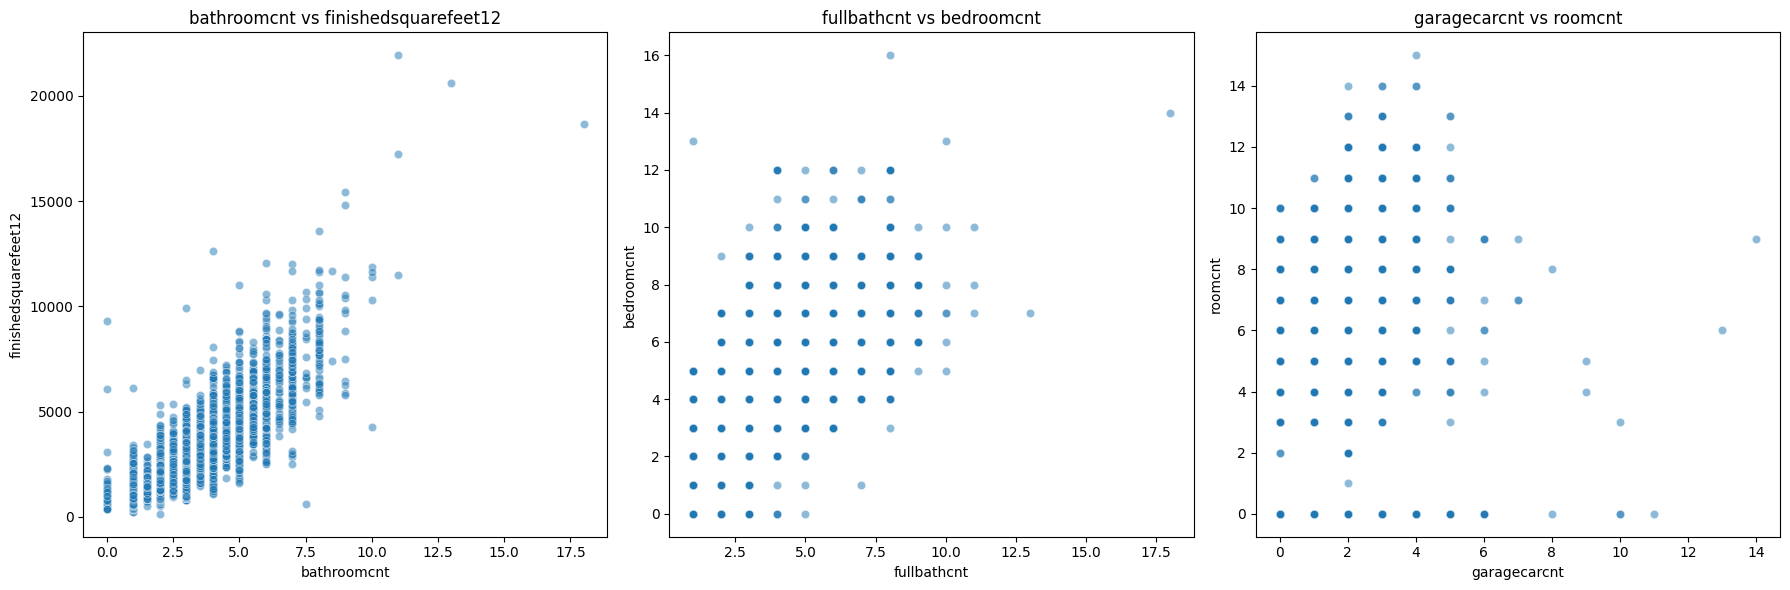

In [ ]:
#Let's select 3 intersting feature pairs and plot them


#bathroomcnt	finishedsquarefeet12	0.811449
#roomcnt	regionidcounty_3101.0	-0.831622
#fullbathcnt	bedroomcnt -0
#garagecarcnt	roomcnt	0.780250



# Define feature pairs
feature_pairs = [
    ('bathroomcnt', 'finishedsquarefeet12'),
    ('fullbathcnt', 'bedroomcnt'),
    ('garagecarcnt', 'roomcnt')
]

# Create scatter plots for the selected pairs
plt.figure(figsize=(18, 6))

# Loop through each feature pair
for i, (feature_x, feature_y) in enumerate(feature_pairs):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=df_cleaned_4a_corr[feature_x], y=df_cleaned_4a_corr[feature_y], alpha=0.5)
    plt.title(f"{feature_x} vs {feature_y}")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)

plt.tight_layout()
plt.show()


#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.

<span style="color:lightblue"> What we see in the above three plots (left to right) are the positive correlations that we would expect given American housing design conventions. We see the following:

- **Bathroom Count vs Finished Sqft** – Larger houses have more bathrooms
- **Full Bathroom Count vs Bedroom Count** – Houses with more bedrooms tend to have more full baths
- **Garage Car Count vs Room Count** – Houses with more overall rooms tend to have garages with more car spaces

<span style="color:lightblue"> In summary, these plots are not very revealing in terms of correlations that could assist us in understanding taxation, but, as said, reinforce construction patterns with American houses. As we continue feature selection and model selection, perhaps more informative patterns will be seen.

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset.
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection).
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary.

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question.

In [14]:
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import PolynomialFeatures


def prep(df):
  df_cleaned_5a = df_cleaned.copy()
  df_cleaned_5a = df_cleaned_5a.drop(columns=["rawcensustractandblock", "parcelid", "propertyzoningdesc", "taxdelinquencyyear"])
  df_cleaned_5a = df_cleaned_5a.map(lambda x: 1 if x is True else (0 if x is False else x))
  tax_flags = []
  for i in df_cleaned_5a["taxdelinquencyflag"]:
    if i == 0:
      tax_flags.append(0)
    else:
      tax_flags.append(1)

  df_cleaned_5a["taxdelinquencyflag"] = tax_flags

  #Impute numeric columns with mean
  numeric_cols = ['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
                  'lotsizesquarefeet', 'regionidcity', 'regionidzip']
  df_cleaned_5a[numeric_cols] = df_cleaned_5a[numeric_cols].fillna(df_cleaned_5a[numeric_cols].mean())

  #Impute specific columns with median
  median_cols = ['fullbathcnt', 'yearbuilt']
  df_cleaned_5a[median_cols] = df_cleaned_5a[median_cols].fillna(df_cleaned_5a[median_cols].median())

  #Impute unitcnt with mode
  df_cleaned_5a['unitcnt'] = df_cleaned_5a['unitcnt'].fillna(df_cleaned_5a['unitcnt'].mode()[0])

  # df_cleaned_5a.isnull().sum().sum()


  return df_cleaned_5a

def feature_scaling(df, columns):
    scaler = preprocessing.StandardScaler()
    scaled_features = scaler.fit_transform(df[columns])
    scaled_df = pd.DataFrame(scaled_features, columns=columns, index=df.index)
    df[columns] = scaled_df
    return df

def log_transformation(df, columns):
    for col in columns:
        df[f"log {col}"] = np.log1p(df[col])
    return df

def exp_transformation(df, columns):
    for col in columns:
        df[col] = np.exp(df[col])
    return df


In [15]:
df_cleaned_5a = prep(df_cleaned)

In [16]:
df_scaled = feature_scaling(df_cleaned_5a, ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr','fullbathcnt', 'garagecarcnt', 'roomcnt', 'unitcnt', 'poolcnt', 'fireplacecnt'])

In [17]:
log_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12','garagetotalsqft', 'lotsizesquarefeet']
df_log = log_transformation(df_scaled.copy(), log_col)


In [18]:
# Adding ratios to the dataset
df_ratio = df_cleaned_5a.copy()

df_ratio['room_size'] = df_ratio['finishedsquarefeet12'] / df_ratio['roomcnt']  # Finished sqft per room
df_ratio['pool_to_lot_ratio'] = df_ratio['poolcnt'] / df_ratio['lotsizesquarefeet']  # Pools to lot size ratio
df_ratio['fireplace_per_room'] = df_ratio['fireplacecnt'] / df_ratio['roomcnt']  # Fireplaces per room
df_ratio['efficiency'] = df_ratio['finishedsquarefeet12'] / df_ratio['lotsizesquarefeet']  # Finished sqft per lot size

In [19]:
# Adding Interactions to the dataset

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

poly_cols = [['finishedsquarefeet12', 'roomcnt'], ['lotsizesquarefeet', 'poolcnt']]

poly = PolynomialFeatures(interaction_only=True)

poly_dfs = []

# Adding interactions between specified pairs in poly_cols
for cols in poly_cols:
    poly_features = poly.fit_transform(df_cleaned_5a[cols])
    poly_feature_names = poly.get_feature_names_out(cols)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

    poly_dfs.append(poly_df)
df_poly = pd.concat([df_cleaned_5a] + poly_dfs, axis=1)

df_poly.columns

df_poly = df_poly.dropna(subset=poly_cols[0])
df_poly = df_poly.dropna(subset=poly_cols[1])

In [20]:
from sklearn.feature_selection import f_regression

def f_score(df):
  y = df['log_taxvaluedollarcnt']
  X = df.drop(columns=['log_taxvaluedollarcnt'])
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  selector = SelectKBest(score_func=f_regression, k='all')
  selector.fit(X_train, y_train)

  f_scores = pd.DataFrame(selector.scores_, index=X_train.columns, columns=["F-Score"]).sort_values(by="F-Score", ascending=False)
  return f_scores


In [21]:
# Getting F_scores for transformed dataframes

log_fscore = f_score(df_log)
poly_fscore = f_score(df_poly)
ratio_fscore = f_score(df_ratio)

In [22]:
log_fscore

F-Score
finishedsquarefeet12              22975.651663
calculatedfinishedsquarefeet      22127.497790
log finishedsquarefeet12          22032.181847
log calculatedfinishedsquarefeet  21823.692946
calculatedbathnbr                 18657.887089
bathroomcnt                       18612.790382
fullbathcnt                       16747.657284
bedroomcnt                         4414.440109
yearbuilt                          3901.673835
heatingorsystemtypeid_7.0          3218.705215
buildingqualitytypeid_4.0          2559.157734
garagetotalsqft                    2358.590998
propertycountylandusecode          2141.588324
poolcnt                            2037.397339
pooltypeid_merged                  2031.279058
buildingqualitytypeid_9.0          2018.355053
garagecarcnt                       1743.667664
buildingqualitytypeid_6.0          1681.305615
buildingqualitytypeid_11.0         1637.736594
log garagetotalsqft                1466.139953
buildingqualitytypeid_7.0          1418.085888
latitude                           1274.456331
buildingqualitytypeid_10.0          988.822227
regionidcounty_3101.0               827.323425
fireplacecnt                        793.982440
buildingqualitytypeid_5.0           713.074684
heatingorsystemtypeid_2.0           442.913279
buildingqualitytypeid_12.0          416.054911
propertylandusetypeid_269.0         157.769101
regionidzip                         152.275140
buildingqualitytypeid_3.0           134.090411
roomcnt                             127.747891
propertylandusetypeid_266.0          97.601714
heatingorsystemtypeid_24.0           97.329270
log lotsizesquarefeet                89.383595
taxdelinquencyflag                   89.088201
longitude                            82.646794
regionidcity                         67.986155
propertylandusetypeid_246.0          57.120798
regionidcounty_2061.0                52.240576
propertylandusetypeid_261.0          41.392354
heatingorsystemtypeid_20.0           40.652958
propertylandusetypeid_248.0          38.408451
propertylandusetypeid_260.0          32.457113
lotsizesquarefeet                    31.980702
buildingqualitytypeid_8.0            28.882599
heatingorsystemtypeid_6.0            22.375163
propertylandusetypeid_265.0          19.064144
propertylandusetypeid_263.0          16.207195
heatingorsystemtypeid_18.0            4.558740
unitcnt                               4.163809
propertylandusetypeid_275.0           3.320784
buildingqualitytypeid_2.0             2.898606
propertylandusetypeid_264.0           0.748621
propertylandusetypeid_267.0           0.456869
heatingorsystemtypeid_13.0            0.300952
heatingorsystemtypeid_11.0            0.024524
propertylandusetypeid_247.0           0.009708
heatingorsystemtypeid_10.0            0.007287

In [23]:
poly_fscore

F-Score
finishedsquarefeet12          20498.627572
calculatedfinishedsquarefeet  19645.124084
calculatedbathnbr             16468.096060
bathroomcnt                   16439.619837
fullbathcnt                   14753.708673
...                                    ...
heatingorsystemtypeid_13.0        0.226486
propertylandusetypeid_247.0       0.008098
heatingorsystemtypeid_11.0        0.000000
1                                 0.000000
1                                 0.000000

[63 rows x 1 columns]

In [24]:
ratio_fscore

F-Score
finishedsquarefeet12          22975.651663
calculatedfinishedsquarefeet  22127.497790
calculatedbathnbr             18657.887089
bathroomcnt                   18612.790382
fullbathcnt                   16747.657284
room_size                      5601.416612
bedroomcnt                     4414.440109
yearbuilt                      3901.673835
heatingorsystemtypeid_7.0      3218.705215
buildingqualitytypeid_4.0      2559.157734
garagetotalsqft                2358.590998
propertycountylandusecode      2141.588324
poolcnt                        2037.397339
pooltypeid_merged              2031.279058
buildingqualitytypeid_9.0      2018.355053
efficiency                     2014.901266
garagecarcnt                   1743.667664
buildingqualitytypeid_6.0      1681.305615
buildingqualitytypeid_11.0     1637.736594
buildingqualitytypeid_7.0      1418.085888
latitude                       1274.456331
pool_to_lot_ratio              1024.414141
buildingqualitytypeid_10.0      988.822227
regionidcounty_3101.0           827.323425
fireplacecnt                    793.982440
buildingqualitytypeid_5.0       713.074684
heatingorsystemtypeid_2.0       442.913279
buildingqualitytypeid_12.0      416.054911
fireplace_per_room              213.467847
propertylandusetypeid_269.0     157.769101
regionidzip                     152.275140
buildingqualitytypeid_3.0       134.090411
roomcnt                         127.747891
propertylandusetypeid_266.0      97.601714
heatingorsystemtypeid_24.0       97.329270
taxdelinquencyflag               89.088201
longitude                        82.646794
regionidcity                     67.986155
propertylandusetypeid_246.0      57.120798
regionidcounty_2061.0            52.240576
propertylandusetypeid_261.0      41.392354
heatingorsystemtypeid_20.0       40.652958
propertylandusetypeid_248.0      38.408451
propertylandusetypeid_260.0      32.457113
lotsizesquarefeet                31.980702
buildingqualitytypeid_8.0        28.882599
heatingorsystemtypeid_6.0        22.375163
propertylandusetypeid_265.0      19.064144
propertylandusetypeid_263.0      16.207195
heatingorsystemtypeid_18.0        4.558740
unitcnt                           4.163809
propertylandusetypeid_275.0       3.320784
buildingqualitytypeid_2.0         2.898606
propertylandusetypeid_264.0       0.748621
propertylandusetypeid_267.0       0.456869
heatingorsystemtypeid_13.0        0.300952
heatingorsystemtypeid_11.0        0.024524
propertylandusetypeid_247.0       0.009708
heatingorsystemtypeid_10.0        0.007287

We chose the logrhimic transformation because the features that contained measure squaredft had skewed distributions which using the log tranformation has the ability to correct. The top three features for this transformation are finishedsquarefeet12, calculatedfinishedsquarefeet, log(finishedsquarefeet12).

The next transformation we did was the Polynomial features only testing interactions between finishedsquarefeet12 and roomcnt features and the  lotsizesquarefeet and poolcnt features. We chose these two because we wanted to see how these pairs of features could interact with each other. The top three features for this transformation again are finishedsquarefeet12, calculatedfinishedsquarefeet, calculatedbathnbr.

The last transformation we did was the ratio transformation. We wanted to understand how the things like room_size, pool_to_lot_ratio, fireplace_per_room, and efficiency. In this the top three features remain the same, but room_size seems to be a relatively important feature.
    

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

